## Predictions
In this notebook, the collected historic energy price and weather data is leveraged to create energy price prediction models. In the end, the following 3 different kinds of models are obtained.

- Cluster model <br>
  This is the model described in the proposal. It consists of 3 layers. Layer 1 predicts the probabilities of the different price clusters occuring on the next day. Layer 2 predicts the hourly energy price within each of the clusters. Layer 3 combines the first two layers by weighting the different hourly price predictions from layer 2 with the cluster probabilities obtained in layer 1, resulting in one final price prediction for each hour.
- Naive approach 1 <br>
  This model simply uses the hourly prices of the previous day as prediction for the following day. E.g. the predicted price for Tuesday 2 pm will be the real price from Monday 2 pm.
- Naive approach 2
  This model directly leverages the collected weather variables as covariates, without predicting any clusters.

### Summary results
Measured with the WAPE (Weighted Absolute Percentage Error) in Denmark, the *cluster model* performed best. In Spain and Norway, best results were achieved with *Naive approach 1*, followed by *cluster model*. *Naive approach 2* was always beaten by *cluster model*.

### Structure
The notebook is structured in the following 4 parts.

### Part 1: Data preparation and cluster predictions

- Import pre-processed historic data from Denmark, Spain and Norway
- Perform a quick check for NAs and if all days in the data have 24 entries (the days on which the time was changed have only 23 and the last day in Denmark only 15 entries).
- Aggregate the variables to daily averages for the cluster predictions.
- Create lags for the energy prices of the last 3 days.
- Add weekend and seasonal dummies.
- Import and match the cluster data with the weather data via the date column.
- Create XGBoost cluster predictions for all 3 countries.
  
### Part 2: Hourly energy price predictions within clusters

- Attach clusters to the data with hourly values.
- Change the format of the date column (no hours needed for this part).
- Add aggregated precipitation variables with $x$ representing the number of days and for $x \in \{3, 7, 14, 20\}$.
- Delete rows with NaNs after adding aggregated precipitation (e.g. if $x=3$ the first day without missing data for aggregated precipitation is day 4).
- Delte columns unnecessary for predicting prices within clusters.
- Split all dataframes by the cluster, resulting in one dataframe for each $x$ and each cluster per country (total of 56 dataframes). These are the dataframes ready for the XGBoost models (within cluster price prediction).
- Drp cluster columns, as they are not needed for wihtin cluster prce prediction.
- Train XGBoost models for hourly energy price predictions within the clusters.

### Part 3: Whole pipeline predictions

- Load the test data for the cluster predictions.
- Send the test data for cluster predictions to the according models and get the probabilities for each cluster on each day in the test data for all countries.
- Load the test data for the within cluster energy price predictions.
- Prepare the test data for the within cluster energy price predictions by selecting the right days and dropping unnecessary columns.
- Load the according within cluster hourly energy price prediction models and calculate the predictions.
- Weigh the predictions with the cluster probabilities to obtain one final price prediction per hour.
- Export the prediction results as csv.
- Visualize the first 48 hours of the predictions and the true prices.
- Evalute the models.

### Part 4: Naive approaches
#### Naive approach one

- Load the hourly data from all 3 countries.
- Rename the date_time column for better intuitive understanding.
- Select the right rows (days) for testing the predictions approach.
- Get the predictions by shifting the hourly energy prices by 1 day.
- Delete rows with NaNs, created due to the shift.
- Visualize the first 48 hours of the predictions and the true prices.
- Evaluate the model.
- Export the prediction results as csv.

#### Naive approach two
 - Load the hourly data with the according aggregated precipitation.
 - Drop rows with NaNs (which were created when aggregating precipitation).
 - Drop columns unnecessary for predictions.
 - Create an XGBoost regression prediction model with the weather variables directly leveraged as covariates.
 - Evaluate the model.
 - Visualize the first 48 hours of the predictions and the true prices.
 - Export the prediction results as csv.

## Part 1: Data preparation and cluster predictions
### Import and quickly check data

Start by importing the data and quickly checking it for NAs. To import the data, the files *DK1_masterset.csv*, *ES_masterset.csv* and *NO2_masterset.csv* have to be stored in a folder called *data*, which has to be stored in the same folder as the notebook. The datafiles are to be found in the github repo under *data/processed*.

### Import DK1

In [1]:
import pandas as pd

# Import data from Denmark
df_dk_original = pd.read_csv("data/DK1_masterset.csv")
# Take a quick look
df_dk_original.head()

,Unnamed: 0,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,1.38,6.745026,2.652963,1.400332,0.0
1,2023-01-01 02:00:00+01:00,0.09,6.788788,2.162854,1.195239,0.0
2,2023-01-01 03:00:00+01:00,0.08,6.770447,2.242519,0.880637,0.0
3,2023-01-01 04:00:00+01:00,0.05,6.767029,2.137281,0.679594,0.0
4,2023-01-01 05:00:00+01:00,0.00,6.659546,2.341132,0.574855,0.0


### Import ES

In [2]:
# Import data from Spain
df_es_original = pd.read_csv("data/ES_masterset.csv")
# Take a quick look
df_es_original.head()

,Unnamed: 0,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,0.0,11.494659,2.592129,0.156290,0.0
1,2023-01-01 02:00:00+01:00,0.0,11.369293,2.643230,0.153099,0.0
2,2023-01-01 03:00:00+01:00,0.0,11.232758,2.716159,0.159135,0.0
3,2023-01-01 04:00:00+01:00,0.0,11.169861,2.804633,0.162722,0.0
4,2023-01-01 05:00:00+01:00,0.0,11.158081,2.885477,0.169517,0.0


### Import NO2

In [3]:
# Import data from Norway
df_no_original = pd.read_csv("data/NO2_masterset.csv")
# Take a quick look
df_no_original.head()

,Unnamed: 0,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,108.83,-0.082153,2.271543,0.000130,0.0
1,2023-01-01 02:00:00+01:00,102.39,-0.478973,2.279109,0.000030,0.0
2,2023-01-01 03:00:00+01:00,92.36,-0.826630,2.516147,0.000161,0.0
3,2023-01-01 04:00:00+01:00,82.66,-1.080292,2.796640,0.000396,0.0
4,2023-01-01 05:00:00+01:00,79.58,-1.228455,3.048621,0.000926,0.0


In [4]:
# Quick check for NAs
print("NAs in Denmark data")
print(df_dk_original.isna().sum())
print("\nNAs in Spain data")
print(df_es_original.isna().sum())
print("\nNAs in Norway data")
print(df_no_original.isna().sum())

NAs in Denmark data
Unnamed: 0           0
price_eur_mwh        0
temperature_2m       0
wind_speed_10m       0
precipitation_mm     0
solar_radiation_W    0
dtype: int64

NAs in Spain data
Unnamed: 0           0
price_eur_mwh        0
temperature_2m       0
wind_speed_10m       0
precipitation_mm     0
solar_radiation_W    0
dtype: int64

NAs in Norway data
Unnamed: 0           0
price_eur_mwh        0
temperature_2m       0
wind_speed_10m       0
precipitation_mm     0
solar_radiation_W    0
dtype: int64


In [5]:
# Create copies of the original data sets, to omit risk of altering original data.
df_dk_copy = df_dk_original.copy()
df_es_copy = df_es_original.copy()
df_no_copy = df_no_original.copy()

### Check for days which do not have 24 entries in the data 

- For all three zones the following days only have 23 entries due to changing the clock: \
  2023-03-26\
  2023-10-29\
  2024-03-31\
  2024-10-27\
  2025-03-30\
  2025-10-26
- Additionally, on 2023-01-01 there are only 23 entries too, because it is the first day of data collection and the first entry obtained was at 01:00 am MET and not 00:00 am MET.
- Furthermore, for **DK1** on 2025-11-24 there were only 15 entries, because it was the last day of data collection for this zone and it was only available until 02:00 pm MET.
- To calculate daily averages of predictor variables, the days containing 23 entries are accecpted since they represent 96% of the day, but 2025-11-24 is omitted for **DK1**, because its 15 hours only represent 63% of the day.

In [6]:
# This function checks which days do not have 24 entries (one for each hour of the day) in the data.
def days_not_24_entries(df, name="df"):
    # The date is in the first column. 
    col0 = df.columns[0]
    # Get the first 10 characters, because they represent the date (after that comes the hour).
    day = df[col0].astype(str).str.slice(0, 10)
    # Count entries per day.
    counts_per_day = day.value_counts().sort_index()
    # Get all days with more or less than 24 entries.
    days_not_24 = counts_per_day[counts_per_day != 24]

    # Print results.
    print(f"\n{name}: Days with != 24 entries")
    if days_not_24.empty:
        print("All days have 24 entries.")
    else:
        print(days_not_24)

# Call function for all 3 zones:
days_not_24_entries(df_dk_copy, "DK")
days_not_24_entries(df_es_copy, "ES")
days_not_24_entries(df_no_copy, "NO")


DK: Days with != 24 entries
Unnamed: 0
2023-01-01    23
2023-03-26    23
2023-10-29    23
2024-03-31    23
2024-10-27    23
2025-03-30    23
2025-10-26    23
2025-11-24    15
Name: count, dtype: int64

ES: Days with != 24 entries
Unnamed: 0
2023-01-01    23
2023-03-26    23
2023-10-29    23
2024-03-31    23
2024-10-27    23
2025-03-30    23
2025-10-26    23
Name: count, dtype: int64

NO: Days with != 24 entries
Unnamed: 0
2023-01-01    23
2023-03-26    23
2023-10-29    23
2024-03-31    23
2024-10-27    23
2025-03-30    23
2025-10-26    23
Name: count, dtype: int64


In [7]:
# Drop the last 15 rows of df_dk_copy (DK1), because that day does not have enough representation.
df_dk_copy.drop(df_dk_copy.tail(15).index, inplace=True)

In [8]:
# Rename the first columns of the data frames to "date_time" to make it more intuitively.
df_dk_copy.rename(columns={df_dk_copy.columns[0]: "date_time"}, inplace=True)
df_es_copy.rename(columns={df_es_copy.columns[0]: "date_time"}, inplace=True)
df_no_copy.rename(columns={df_no_copy.columns[0]: "date_time"}, inplace=True)

### Preview Part 2

Later in this project, energy prices within each cluster are predicted based on the hourly weahter variables values. Therefore, a copy of each countries dataframe is created at this point to be leveraged later.

In [9]:
df_dk_copy_part2 = df_dk_copy.copy()
df_es_copy_part2 = df_es_copy.copy()
df_no_copy_part2 = df_no_copy.copy()

### End Preview Part 2

### Aggregate daily values

In order for the cluster predictions to work as agreed in the proposal, daily values are needed. Therefore, these are calculated in the next step, leveraging the function *make_daily_values*.

In [10]:
def make_daily_values(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Create a 'date' column from the first 10 characters (YYYY-MM-DD)
    # Convert it to datetime to get a proper date type and sorting.
    df["date"] = pd.to_datetime(df["date_time"].astype(str).str.slice(0, 10), errors="coerce")

    # Group by date and aggregate columns to daily values
    daily = (
        df.groupby("date", as_index=False)
          .agg(
              avg_temperature=("temperature_2m", "mean"),
              avg_wind_speed=("wind_speed_10m", "mean"),
              sum_precipitation=("precipitation_mm", "sum"),
              sum_solar_radiation=("solar_radiation_W", "sum"),
              avg_price=("price_eur_mwh", "mean"),
          )
          .sort_values("date")
          .reset_index(drop=True)
    )

    return daily

In [11]:
# Call the function with the data frames.
df_dk_daily_values = make_daily_values(df_dk_copy)
df_es_daily_values = make_daily_values(df_es_copy)
df_no_daily_values = make_daily_values(df_no_copy)

df_dk_daily_values.head()

,date,avg_temperature,avg_wind_speed,sum_precipitation,sum_solar_radiation,avg_price
0,2023-01-01,7.144257,4.813036,9.061149,299.366835,17.166522
1,2023-01-02,6.628073,3.582617,8.062369,182.326114,124.130000
2,2023-01-03,4.937889,5.088700,1.301959,504.450015,145.954583
3,2023-01-04,7.369996,8.379322,20.889447,160.687176,58.941667
4,2023-01-05,3.833658,5.219192,0.700582,380.802743,107.460417


### Create Lagged dataframes

The predictions for the clusters build on daily values for the weather variables and on the data of the last 3 days in case of the energy price level. Therefore, using the function *make_cluster_pred*, in a next step lagged entries for the energy price levels of the last 3 days are added to the dataframes through the columns:

- avg_price_1: representing the average energy price of the day before the day in the date column
- avg_price_2: representing the average energy price from two days before the day in the date column
- avg_price_3: representing the average energy price from three days before the day in the date column

In [12]:
def make_cluster_pred(df_daily: pd.DataFrame) -> pd.DataFrame:
    df = df_daily.copy()

    # Ensure correct chronological order before shifting
    df = df.sort_values("date").reset_index(drop=True)

    # Add price lags of the last 2 days
    df["avg_price_1"] = df["avg_price"].shift(1)
    df["avg_price_2"] = df["avg_price"].shift(2)
    df["avg_price_3"] = df["avg_price"].shift(3)

    # Drop the first 3 rows (they have missing lag values)
    df = df.dropna().reset_index(drop=True)
    df = df.drop(columns=["avg_price"])

    return df

In [13]:
# Call the function with the data frames.
df_dk_cluster_pred = make_cluster_pred(df_dk_daily_values)
df_es_cluster_pred = make_cluster_pred(df_es_daily_values)
df_no_cluster_pred = make_cluster_pred(df_no_daily_values)

df_dk_cluster_pred.head()

,date,avg_temperature,avg_wind_speed,sum_precipitation,sum_solar_radiation,avg_price_1,avg_price_2,avg_price_3
0,2023-01-04,7.369996,8.379322,20.889447,160.687176,145.954583,124.130000,17.166522
1,2023-01-05,3.833658,5.219192,0.700582,380.802743,58.941667,145.954583,124.130000
2,2023-01-06,6.062777,7.943929,11.770651,350.920449,107.460417,58.941667,145.954583
3,2023-01-07,7.437405,6.882981,2.400484,198.335070,116.848750,107.460417,58.941667
4,2023-01-08,7.234395,7.320955,2.225076,389.714019,88.808750,116.848750,107.460417


### Add calendarial dummies

Dummy variables, indicating if a day is a weekday/weekend and what season the day is part of (spring, summer, autumn, winter) shall be included too. The functions *add_weekend_dummy* and *add_season_dummies* take care of this.

In [14]:
def add_weekend_dummy(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    df = df.copy()
    # Ensure the date column is datetime (needed for .dt)
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    # Weekend dummy: 1 = weekend (Sat/Sun), 0 = weekday
    df["is_weekend"] = (df[date_col].dt.dayofweek >= 5).astype(int)

    return df

In [15]:
df_dk_cluster_pred = add_weekend_dummy(df_dk_cluster_pred)
df_es_cluster_pred = add_weekend_dummy(df_es_cluster_pred)
df_no_cluster_pred = add_weekend_dummy(df_no_cluster_pred)

df_dk_cluster_pred[:10]

,date,avg_temperature,avg_wind_speed,sum_precipitation,sum_solar_radiation,avg_price_1,avg_price_2,avg_price_3,is_weekend
0,2023-01-04,7.369996,8.379322,20.889447,160.687176,145.954583,124.130000,17.166522,0
1,2023-01-05,3.833658,5.219192,0.700582,380.802743,58.941667,145.954583,124.130000,0
2,2023-01-06,6.062777,7.943929,11.770651,350.920449,107.460417,58.941667,145.954583,0
3,2023-01-07,7.437405,6.882981,2.400484,198.335070,116.848750,107.460417,58.941667,1
4,2023-01-08,7.234395,7.320955,2.225076,389.714019,88.808750,116.848750,107.460417,1
5,2023-01-09,5.964905,5.672954,3.269259,365.848141,68.941667,88.808750,116.848750,0
6,2023-01-10,6.043435,6.445977,1.752290,565.671562,129.196667,68.941667,88.808750,0
7,2023-01-11,7.276168,9.559114,9.442154,600.542291,123.045417,129.196667,68.941667,0
8,2023-01-12,6.401669,6.411645,6.159984,262.805359,83.005000,123.045417,129.196667,0
9,2023-01-13,6.832015,8.658555,5.960471,264.896502,74.637500,83.005000,123.045417,0


In [16]:
def add_season_dummies(df, date_col="date"):
    # Day of year as integer (1..366, leap years (Schaltjahre) handled automatically)
    doy = df[date_col].dt.dayofyear

    # Reference cut-off days (using a non-leap year)
    spring_start = pd.Timestamp("2001-03-21").dayofyear  # March 21
    summer_start = pd.Timestamp("2001-06-21").dayofyear  # June 21
    autumn_start = pd.Timestamp("2001-09-21").dayofyear  # September 21
    winter_start = pd.Timestamp("2001-12-21").dayofyear  # December 21

    # Create dummy variables
    df["season_spring"] = ((doy >= spring_start) & (doy < summer_start)).astype(int)
    df["season_summer"] = ((doy >= summer_start) & (doy < autumn_start)).astype(int)
    df["season_autumn"] = ((doy >= autumn_start) & (doy < winter_start)).astype(int)

    # Winter is implicitly encoded when all three dummies are 0
    return df

In [17]:
df_dk_cluster_pred = add_season_dummies(df_dk_cluster_pred)
df_es_cluster_pred = add_season_dummies(df_es_cluster_pred)
df_no_cluster_pred = add_season_dummies(df_no_cluster_pred)

In [18]:
print(df_dk_cluster_pred[75:85])
print(df_dk_cluster_pred[165:175])
print(df_dk_cluster_pred[259:269])
print(df_dk_cluster_pred[349:359])

         date  avg_temperature  avg_wind_speed  sum_precipitation  \
75 2023-03-20         5.814344        5.412247           0.871034   
76 2023-03-21         5.311654        4.294591           4.961322   
77 2023-03-22         7.348918        7.917060           5.762561   
78 2023-03-23         7.593960        7.471857           3.843697   
79 2023-03-24         7.643916        8.223324           6.850122   
80 2023-03-25         6.813264        5.719112           3.458777   
81 2023-03-26         3.750321        5.032387           0.590695   
82 2023-03-27         1.984731        5.806834           1.171369   
83 2023-03-28         2.584690        4.193999           0.875450   
84 2023-03-29         4.813056        3.926255           3.214320   

    sum_solar_radiation  avg_price_1  avg_price_2  avg_price_3  is_weekend  \
75          2252.983967   111.992083   109.337500    85.566667           0   
76           848.593898   122.695417   111.992083   109.337500           0   
77    

### Add clusters

In order for clusters to be predicted, the cluster of each day needs to be added to the data frame. These clusters were obtained in the notebooks *DK1_pattern_detection.ipynb*, *ES_pattern_detection* and *NO2_pattern_detection.ipynb* and are now imported from the files *DK1_date_cluster.csv*, *ES_date_cluster.csv* and *NO2_date_cluster.csv*. In order for the code to work, these files need to be stored in the same *data* folder as the mastersets, which has to be stored in the same folder as the notebook.

In [19]:
# Import the clusters
clusters_dk = pd.read_csv("data/DK1_date_cluster.csv")
clusters_es = pd.read_csv("data/ES_date_cluster.csv")
clusters_no = pd.read_csv("data/NO2_date_cluster.csv")

In [20]:
clusters_dk.head()

,date,cluster
0,2023-01-01 00:00:00+00:00,5
1,2023-01-02 00:00:00+00:00,1
2,2023-01-03 00:00:00+00:00,2
3,2023-01-04 00:00:00+00:00,3
4,2023-01-05 00:00:00+00:00,1


In [21]:
def attach_cluster(df_pred: pd.DataFrame, clusters: pd.DataFrame) -> pd.DataFrame:
    df_pred = df_pred.copy()
    clusters = clusters.copy()

    # Build a stable merge key: 'YYYY-MM-DD'
    df_pred["_date_key"] = df_pred["date"].astype(str).str.slice(0, 10)
    clusters["_date_key"] = clusters["date"].astype(str).str.slice(0, 10)

    # Left-join: keep all rows from df_pred, add matching cluster
    out = df_pred.merge(
        clusters[["_date_key", "cluster"]],
        on="_date_key",
        how="left"
    )

    # Cleanup
    out = out.drop(columns=["_date_key"])

    return out

In [22]:
# Add the cluster calling the function above.
df_dk_cluster_pred = attach_cluster(df_dk_cluster_pred, clusters_dk)
df_es_cluster_pred = attach_cluster(df_es_cluster_pred, clusters_es)
df_no_cluster_pred = attach_cluster(df_no_cluster_pred, clusters_no)

df_dk_cluster_pred.head()

,date,avg_temperature,avg_wind_speed,sum_precipitation,sum_solar_radiation,avg_price_1,avg_price_2,avg_price_3,is_weekend,season_spring,season_summer,season_autumn,cluster
0,2023-01-04,7.369996,8.379322,20.889447,160.687176,145.954583,124.130000,17.166522,0,0,0,0,3
1,2023-01-05,3.833658,5.219192,0.700582,380.802743,58.941667,145.954583,124.130000,0,0,0,0,1
2,2023-01-06,6.062777,7.943929,11.770651,350.920449,107.460417,58.941667,145.954583,0,0,0,0,1
3,2023-01-07,7.437405,6.882981,2.400484,198.335070,116.848750,107.460417,58.941667,1,0,0,0,4
4,2023-01-08,7.234395,7.320955,2.225076,389.714019,88.808750,116.848750,107.460417,1,0,0,0,3


### Create XGBoost cluster predictions
Now the dataframes have all the information necessary to predict the clusters as described in the proposal. Therefore, in the next step for each country a XGBoost model is created to predict the probabilities of occurence of the different clusters. The models are named *xgb_cluster_model_DK*, *xgb_cluster_model_ES* as well as *xgb_cluster_model_NO* and are stored as joblib files in the same folder as the notebook, after running the respective code. Currently, this code is in comments to prevent the already trained models from being overwritten.

In [23]:
# Target variable has to be an integer -> convert
df_dk_cluster_pred["cluster"] = df_dk_cluster_pred["cluster"].astype("int64")
df_es_cluster_pred["cluster"] = df_es_cluster_pred["cluster"].astype("int64")
df_no_cluster_pred["cluster"] = df_no_cluster_pred["cluster"].astype("int64")

In [24]:
!pip install -U xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 204.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 165.3 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.1 requires nvidia-cublas-cu12==12.8.4.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.9.1 requires nvidia-cuda-cupti-cu12==12.8.90; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.9.1 requires nvidia-cuda-nvrtc-cu12==12.8.93; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.9.1 requires nvidia-cuda-runtime-cu12==12.8.90; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.9.1 requires nvidia-cufile-cu12==1.13.1.3; platform_system == "Linux" and platfor

In [25]:
import numpy as np
import os

from pathlib import Path
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Train a simple multi-class XGBoost classifier with a chronological 70/15/15 split.
# Target: cluster
# Predictors: all columns except date and cluster
# Split strategy:
#      - first 70% of days -> train
#      - next 15% -> validation (used for early stopping)
#      - last 15% -> test (final evaluation)
def train_xgb(df: pd.DataFrame, name: str = "country", random_state: int = 42, out_dir: str = "metrics", append_to_global: bool = True):
    # -----------------------------
    # 1) Defensive copy + sort by time
    # -----------------------------
    df = df.copy().sort_values("date").reset_index(drop=True)
    # Keep only rows with a target and ensure integer classes
    df = df.dropna(subset=["cluster"])
    df["cluster"] = df["cluster"].astype(int)

    # -----------------------------
    # 2) Build feature matrix X and target y
    # -----------------------------
    feature_cols = [c for c in df.columns if c not in ["date", "cluster"]]
    X = df[feature_cols]
    
    # XGBoost expects classification labels to start with 0 and go on until K-1.
    # Our clusters start with 1 and go until K, therefore we need to encode the 
    # target variable cluster.
    le = LabelEncoder()
    y = le.fit_transform(df["cluster"])   # now labels are 0..K-1

    # -----------------------------
    # 3) Chronological 70/15/15 split (no shuffle because it is a time series)
    # -----------------------------
    n = len(df)
    n_train = int(np.floor(n * 0.70))
    n_val   = int(np.floor(n * 0.15))
    # rest is test

    X_train, y_train = X.iloc[:n_train], y[:n_train]
    X_val,   y_val   = X.iloc[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test,  y_test  = X.iloc[n_train+n_val:], y[n_train+n_val:]

    print(f"\n[{name}] rows: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
    print(f"[{name}] original clusters: {list(le.classes_)}")

    # -----------------------------
    # 4) Simple XGBoost multi-class model
    #    - objective='multi:softprob' => predict_proba works for multi-class
    #    - early stopping uses validation set
    # -----------------------------
    model = XGBClassifier(
        objective="multi:softprob", # set class probabilities as goal
        eval_metric="mlogloss",     # multiclass log loss; small penalties if prediction is close to right, great penalty if the prediction is far away from right
        n_estimators=2000,          # large; early stopping will probably stop earlier
        learning_rate=0.05,         # learning rate; indicating allowed improvement per new tree
        max_depth=6,                # maximum depth of each tree
        subsample=0.9,              # bagging; only use random 90% subsample of rows per tree
        colsample_bytree=0.9,       # random sub space; only use random 90% of features per tree
        reg_lambda=1.0,             # regularization strength on leaf weights (helps reduce overfitting)
        early_stopping_rounds=50,   # stop training if the validation metric doesn't improve for 50 rounds
        random_state=random_state,  # reproducibility (controls randomness in subsampling/column sampling)
        n_jobs=-1                   # use all available CPU cores for faster training
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # -----------------------------
    # 5) Evaluate on test set
    # -----------------------------
    proba_test = model.predict_proba(X_test)             # probabilities per class
    pred_enc = proba_test.argmax(axis=1)

    # Get the accuracy of predictions
    test_acc = accuracy_score(y_test, pred_enc)
    print(f"[{name}] test accuracy: {test_acc:.4f}")
    # Log loss is good because we care about probabilities
    test_ll = log_loss(y_test, proba_test)
    print(f"[{name}] test logloss: {test_ll:.5f}")
    # Decode predictions back to original cluster labels for reporting
    pred_labels = le.inverse_transform(pred_enc)
    true_labels = le.inverse_transform(y_test)

    # Get classification report as dictionary.
    report_dict = classification_report(true_labels, pred_labels, output_dict = True, zero_division=0)
    # Transform to dataframe directly.
    report_df = pd.DataFrame(report_dict).T.reset_index().rename(columns={"index": "label"})
    # Add meta data.
    report_df.insert(0, "country", name)
    report_df["n_train"] = len(X_train)
    report_df["n_val"]   = len(X_val)
    report_df["n_test"]  = len(X_test)
    report_df["test_accuracy"] = test_acc
    report_df["test_logloss"]  = test_ll
    report_df["classes"] = [",".join(map(str, le.classes_))] * len(report_df)

    print(classification_report(true_labels, pred_labels))

    # Safe the dataframe as file.
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    report_df.to_csv(out_path / f"xgb_eval_{name}.csv", index=False)

    splits = {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val,     "y_val": y_val,
        "X_test": X_test,   "y_test": y_test
    }

    return model, feature_cols, le, splits, report_df

In [26]:
import joblib # to safe the models

# Call the function to train the 3 models.

"""
------------------------------------------------------------------------------
Currently in comments to prevent the safed xgboost models from being overwritten!
------------------------------------------------------------------------------

model_dk, feats_dk, le_dk, splits_dk, rep_dk = train_xgb(df_dk_cluster_pred, name="DK")
model_es, feats_es, le_es, splits_es, rep_es = train_xgb(df_es_cluster_pred, name="ES")
model_no, feats_no, le_no, splits_no, rep_no = train_xgb(df_no_cluster_pred, name="NO")

# Safe Denmark model.
bundle_dk = {
    "model": model_dk,
    "feature_cols": feats_dk,
    "label_encoder": le_dk
}
joblib.dump(bundle_dk, "xgb_cluster_model_DK.joblib")

# Safe Spain model.
bundle_es = {
    "model": model_es,
    "feature_cols": feats_es,
    "label_encoder": le_es
}
joblib.dump(bundle_es, "xgb_cluster_model_ES.joblib")

# Safe Norway model.
bundle_no = {
    "model": model_no,
    "feature_cols": feats_no,
    "label_encoder": le_no
}
joblib.dump(bundle_no, "xgb_cluster_model_NO.joblib")
"""

'\n------------------------------------------------------------------------------\nCurrently in comments to prevent the safed xgboost models from being overwritten!\n------------------------------------------------------------------------------\n\nmodel_dk, feats_dk, le_dk, splits_dk, rep_dk = train_xgb(df_dk_cluster_pred, name="DK")\nmodel_es, feats_es, le_es, splits_es, rep_es = train_xgb(df_es_cluster_pred, name="ES")\nmodel_no, feats_no, le_no, splits_no, rep_no = train_xgb(df_no_cluster_pred, name="NO")\n\n# Safe Denmark model.\nbundle_dk = {\n    "model": model_dk,\n    "feature_cols": feats_dk,\n    "label_encoder": le_dk\n}\njoblib.dump(bundle_dk, "xgb_cluster_model_DK.joblib")\n\n# Safe Spain model.\nbundle_es = {\n    "model": model_es,\n    "feature_cols": feats_es,\n    "label_encoder": le_es\n}\njoblib.dump(bundle_es, "xgb_cluster_model_ES.joblib")\n\n# Safe Norway model.\nbundle_no = {\n    "model": model_no,\n    "feature_cols": feats_no,\n    "label_encoder": le_no\n}\n

## Part 2: Hourly energy price predictions within clusters

Part 2 is about creating the different prediction models within each cluster to obtain hourly values for the energy price and about finding out what amount of days is best for aggregated precipitation in each country.

In [27]:
df_dk_copy_part2[:5]

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,1.38,6.745026,2.652963,1.400332,0.0
1,2023-01-01 02:00:00+01:00,0.09,6.788788,2.162854,1.195239,0.0
2,2023-01-01 03:00:00+01:00,0.08,6.770447,2.242519,0.880637,0.0
3,2023-01-01 04:00:00+01:00,0.05,6.767029,2.137281,0.679594,0.0
4,2023-01-01 05:00:00+01:00,0.00,6.659546,2.341132,0.574855,0.0


To start, the function *attach_cluster()* is leveraged again to add the clusters to each hourly entry in the data, such that the data can be sorted later. Additionally, the *date* column is transformed, because for this part of the project only the day and not the single hours are needed.

In [28]:
# Rename the first column in the dataframes to "date" so the function "attach_cluster()" from above to add the clusters can be leveraged again.
# Additionally only use the days (no hour in date column) because that makes problems and each row represents a hour anyways.
df_dk_copy_part2["date"] = pd.to_datetime(df_dk_copy_part2["date_time"].astype(str).str.slice(0, 10), errors="coerce")
df_es_copy_part2["date"] = pd.to_datetime(df_es_copy_part2["date_time"].astype(str).str.slice(0, 10), errors="coerce")
df_no_copy_part2["date"] = pd.to_datetime(df_no_copy_part2["date_time"].astype(str).str.slice(0, 10), errors="coerce")

df_dk_copy_part2[:5]

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,date
0,2023-01-01 01:00:00+01:00,1.38,6.745026,2.652963,1.400332,0.0,2023-01-01
1,2023-01-01 02:00:00+01:00,0.09,6.788788,2.162854,1.195239,0.0,2023-01-01
2,2023-01-01 03:00:00+01:00,0.08,6.770447,2.242519,0.880637,0.0,2023-01-01
3,2023-01-01 04:00:00+01:00,0.05,6.767029,2.137281,0.679594,0.0,2023-01-01
4,2023-01-01 05:00:00+01:00,0.00,6.659546,2.341132,0.574855,0.0,2023-01-01


In [29]:
df_dk_copy_part2 = df_dk_copy_part2.drop(columns=["date_time"])
df_es_copy_part2 = df_es_copy_part2.drop(columns=["date_time"])
df_no_copy_part2 = df_no_copy_part2.drop(columns=["date_time"])

df_dk_copy_part2[:5]

,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,date
0,1.38,6.745026,2.652963,1.400332,0.0,2023-01-01
1,0.09,6.788788,2.162854,1.195239,0.0,2023-01-01
2,0.08,6.770447,2.242519,0.880637,0.0,2023-01-01
3,0.05,6.767029,2.137281,0.679594,0.0,2023-01-01
4,0.00,6.659546,2.341132,0.574855,0.0,2023-01-01


In [30]:
# Add the clusters calling the function defined above in part 1.
df_dk_copy_part2 = attach_cluster(df_dk_copy_part2, clusters_dk)
df_es_copy_part2 = attach_cluster(df_es_copy_part2, clusters_es)
df_no_copy_part2 = attach_cluster(df_no_copy_part2, clusters_no)

df_dk_copy_part2.head()

,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,date,cluster
0,1.38,6.745026,2.652963,1.400332,0.0,2023-01-01,5
1,0.09,6.788788,2.162854,1.195239,0.0,2023-01-01,5
2,0.08,6.770447,2.242519,0.880637,0.0,2023-01-01,5
3,0.05,6.767029,2.137281,0.679594,0.0,2023-01-01,5
4,0.00,6.659546,2.341132,0.574855,0.0,2023-01-01,5


In [31]:
# Check how many unique clusters there are in each dataframe.
print(df_dk_copy_part2["cluster"].nunique())
print(df_es_copy_part2["cluster"].nunique())
print(df_no_copy_part2["cluster"].nunique())

6
3
5


In [32]:
len(df_dk_copy_part2)

25385

### Add aggregated precipitation

One of the explanatory variables is going to be the aggregated precipitation of the last $x$ days with $x \in \{3, 7, 14, 20\}$. Therefore, next dataframes with these aggregated precipitation variables are created. After this step, the dataframes can be accessed following this schema: <br>
dfs_agg_precipitation["country_code"][x] <br>
country_code...dk for Denkmark, no for Norway and es for Spain <br>
x...representing the number of days used for aggregating precipitation; $x \in \{3, 7, 14, 20\}$

In [33]:
# Collect inputs in a dict for clean looping
dfs = {
    "dk": df_dk_copy_part2,
    "es": df_es_copy_part2,
    "no": df_no_copy_part2,
}

windows_days = (3, 7, 14, 20)

def add_precipitation_last_x_days(df: pd.DataFrame, x: int) -> pd.DataFrame:
    df = df.copy()  # keep originals untouched

    # Ensure "date" is day-level
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()

    # Aggregate hourly precipitation to daily totals
    daily = (
        df.groupby("date", as_index=False)["precipitation_mm"]
          .sum()
          .sort_values("date")
    )

    out_col = f"precipitation_last_{x}_days"
    daily[out_col] = (
        daily["precipitation_mm"]
        .shift(1)                      # drop "today" from the window
        .rolling(window=x, min_periods=x)
        .sum()
    )

    # Merge daily rolling values back to the original hourly rows by "date"
    df = df.merge(daily[["date", out_col]], on="date", how="left")

    return df

In [34]:
# Call the function above to add the aggregated precipitation columns.
# dfs_agg_precipitation["dk"][7] -> DK df with precipitation_last_7_days (same value repeated for all hours of the day).
dfs_agg_precipitation = {
    name: {x: add_precipitation_last_x_days(df, x) for x in windows_days}
    for name, df in dfs.items()
}

In [35]:
# Take a quick look
print(dfs_agg_precipitation["dk"][3])

       price_eur_mwh  temperature_2m  wind_speed_10m  precipitation_mm  \
0               1.38        6.745026        2.652963          1.400332   
1               0.09        6.788788        2.162854          1.195239   
2               0.08        6.770447        2.242519          0.880637   
3               0.05        6.767029        2.137281          0.679594   
4               0.00        6.659546        2.341132          0.574855   
...              ...             ...             ...               ...   
25380          83.80        3.034515        9.009330          0.052493   
25381          77.41        2.891785        8.958768          0.056595   
25382          74.16        2.675384        8.867300          0.075576   
25383          73.42        2.442291        8.639704          0.123786   
25384          69.31        2.337891        7.642588          0.184048   

       solar_radiation_W       date  cluster  precipitation_last_3_days  
0                    0.0 2023-01-01  

Now there are NaN values in the aggregated precipitation columns, where there have not been enough days before to create the aggregated values (e.g. if $x=7$ then the first day with aggregated precipitation of the last $7$ days is day $8$). These NaNs are dropped next.

Additonally, all rows, which are test data for the XGBoost model predicting the clusters, are deleted here too, to prevent the test data from being fed to the coming XGBoost models. These rows are later leveraged again as test data.

### Preview Part 3

The entries utilized as test data will be cut off next. Before, copies of the current dataframes are made, so they can be leveraged again in Part 3 of the notebook, where the final price predictions are done.

In [36]:
dfs_agg_precipitation_part3 = dfs_agg_precipitation.copy()

### End Preview Part 3

In [37]:
cutoff_by_country = {
    "dk": pd.Timestamp("2025-06-18"),  # rows after this go to train_data dict DK
    "es": pd.Timestamp("2025-06-20"),  # rows after this go to train_data dict ES
    "no": pd.Timestamp("2025-06-20"),  # rows after this go to train_data dict NO
}

# Store the cut-off part (date >= cutoff) before removing it from dfs_agg_precipitation
dfs_agg_precipitation_train_data = {
    country: {
        x: (
            df.dropna(subset=[f"precipitation_last_{x}_days"])
              .loc[lambda d: pd.to_datetime(d["date"]) >= cutoff_by_country[country]]
              .reset_index(drop=True)
        )
        for x, df in dfx.items()
    }
    for country, dfx in dfs_agg_precipitation.items()
}

# Keep only the part before cutoff (date < cutoff) in the original dict
dfs_agg_precipitation = {
    country: {
        x: (
            df.dropna(subset=[f"precipitation_last_{x}_days"])
              .loc[lambda d: pd.to_datetime(d["date"]) < cutoff_by_country[country]]
              .reset_index(drop=True)
        )
        for x, df in dfx.items()
    }
    for country, dfx in dfs_agg_precipitation.items()
}

In [38]:
# Take a quick look
print(dfs_agg_precipitation["no"][7])

       price_eur_mwh  temperature_2m  wind_speed_10m  precipitation_mm  \
0              24.44        5.840759        7.692393          1.483185   
1               9.36        5.756653        7.604342          1.623969   
2               9.39        5.739899        7.844725          1.819840   
3               4.29        5.700806        7.993162          1.694403   
4               5.76        5.787262        7.887729          1.545791   
...              ...             ...             ...               ...   
21446          72.15       14.789795        5.458452          0.000178   
21447          81.83       14.410095        5.324345          0.000000   
21448          89.88       13.928589        5.285136          0.000081   
21449          89.85       13.278320        5.335078          0.000000   
21450          85.49       12.447052        5.206160          0.000000   

       solar_radiation_W       date  cluster  precipitation_last_7_days  
0               0.000000 2023-01-08  

### Delete columns unnecessary for predictions

Next the columns *date* and *precipitation_mm* are deleted, because they are no longer needed.

In [39]:
cols_to_drop = ["date", "precipitation_mm"]

dfs_agg_precipitation = {
    country: {
        x: df.drop(columns=cols_to_drop, errors="ignore")
        for x, df in dfx.items()
    }
    for country, dfx in dfs_agg_precipitation.items()
}

In [40]:
# Take a quick look
print(dfs_agg_precipitation["es"][20])

       price_eur_mwh  temperature_2m  wind_speed_10m  solar_radiation_W  \
0              75.76        8.365417        2.117829           0.000000   
1              60.50        8.181000        2.338902           0.000000   
2              56.00        7.926605        2.563540           0.000000   
3              52.00        7.766357        2.817303           0.000000   
4              50.00        7.553589        3.058041           0.000000   
...              ...             ...             ...                ...   
21134         123.00       27.882538        0.562584         394.232150   
21135         133.22       27.075653        0.800475         239.899670   
21136         167.55       26.034119        0.918406         111.212685   
21137         164.60       24.697052        1.028785          18.890514   
21138         133.02       23.616943        1.099813           0.046955   

       cluster  precipitation_last_20_days  
0            3                   51.902427  
1        

### Split by cluster
Next all dataframes in dfs_agg_precipitation are split by their cluster. This means, after the next splitting, there is a dataframe which holds all columns for Denmark, where the cluster is 1 and precipitation is aggregated for the last 3 days, one where the cluster is 1 and the precipitation is aggregated for the last 7 days, and so on for all clusters and all variations of aggregated precipitation and all countries, resulting in a total of 56 dataframes stored in *split_dfs*. The dataframes can then be accessed following this schema: <br>
splits_dfs["country_code"][x][y] <br>
country_code...df for Denkmark, no for Norway and es for Spain <br>
x...representing the number of days used for aggregating precipitation; $x \in \{3, 7, 14, 20\}$ <br>
y...representing the cluster value (6 clusters available for Denmark, 3 for Spain and 5 for Norway)

In [41]:
# Split every dataframe by its "cluster" column and store as nested dict:
# split_dfs[country][number of days for aggregated precipitation][cluster_value] -> dataframe for that cluster
split_dfs = {
    country: {
        x: {# x...number of days for aggregated precipitation
            c: g.reset_index(drop=True)          # keep clean row index; c...cluster value
            for c, g in df.groupby("cluster")    # split by cluster values; g...group of rows with the corresponding cluster
        }
        for x, df in dfx.items()
    }
    for country, dfx in dfs_agg_precipitation.items()
}

In [42]:
# Take a quick look
split_dfs["es"][7][3]

,price_eur_mwh,temperature_2m,wind_speed_10m,solar_radiation_W,cluster,precipitation_last_7_days
0,5.10,13.006805,6.168115,0.000000,3,15.946533
1,4.20,12.908691,6.108733,0.000000,3,15.946533
2,4.20,12.781769,6.021466,0.000000,3,15.946533
3,4.20,12.615723,5.937158,0.000000,3,15.946533
4,4.60,12.423370,5.799343,0.000000,3,15.946533
...,...,...,...,...,...,...
10290,123.17,28.841888,0.574466,433.190460,3,5.417725
10291,139.03,28.011597,0.482795,256.050600,3,5.417725
10292,194.56,26.731506,0.288578,114.417280,3,5.417725
10293,166.75,25.224670,0.175233,18.671453,3,5.417725


In [43]:
# Sanity Check: Does the expected number of dataframes on each level exist?
# Yes!
print(len(split_dfs))
print(len(split_dfs["dk"]))
print(len(split_dfs["dk"][3]))
print(len(split_dfs["dk"][7]))
print(len(split_dfs["dk"][14]))
print(len(split_dfs["dk"][20]))

print(len(split_dfs["es"]))
print(len(split_dfs["es"][3]))
print(len(split_dfs["es"][7]))
print(len(split_dfs["es"][14]))
print(len(split_dfs["es"][20]))

print(len(split_dfs["no"]))
print(len(split_dfs["no"][3]))
print(len(split_dfs["no"][7]))
print(len(split_dfs["no"][14]))
print(len(split_dfs["no"][20]))

3
4
6
6
6
6
4
3
3
3
3
4
5
5
5
5


### Drop cluster columns

Next the *cluster* columns are dropped, because they are not needed for the predictions. After that, the dataframes are ready for the prediction models within each cluster.

In [44]:
# Drop the "cluster" column from every dataframe in split_dfs
split_dfs = {
    country: {
        x: {
            c: g.drop(columns=["cluster"], errors="ignore")
            for c, g in clusters.items()
        }
        for x, clusters in by_x.items()
    }
    for country, by_x in split_dfs.items()
}

### XGBoost hourly prediction models
In the next step XGBoost models are trained to predict the hourly values of the energy price within each cluster of all zones. The models are stored as joblib files in the folder *price_models* and follow this naming schema: <br>
xgb_price_country-code_px_cy <br>
country-code...df for Denkmark, no for Norway and es for Spain <br>
x...representing the number of days used for aggregating precipitation; $x \in \{3, 7, 14, 20\}$ <br>
y...representing the cluster value (6 clusters available for Denmark, 3 for Spain and 5 for Norway) <br>
E.g. "xgb_price_DK_p3_c1" for Denmark, 3 days used for aggregating precipitation and predicting the price within cluster 1

In [45]:
import os

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

# where to store models on disk
MODEL_DIR = "price_models"
os.makedirs(MODEL_DIR, exist_ok=True)

def xgb_price_within_cluster(df: pd.DataFrame, model_name: str):
    """
    Train one XGBoost regressor on one dataframe.
    Target: price_eur_mwh
    Predictors: all columns except price_eur_mwh and cluster
    Split (by row order): 70% train, 15% val, 15% test
    Saves model to MODEL_DIR/model_name.json
    Returns: (model, rmse, mape_percent)
    """
    # Keep the original order (assumed time order); just ensure clean integer index
    df = df.reset_index(drop=True)

    # Define target and features (drop cluster and target)
    y = df["price_eur_mwh"]
    X = df.drop(columns=["price_eur_mwh", "cluster"], errors="ignore")

    # Store feature columns so you can rebuild X_new later in the same order
    feature_cols = X.columns.tolist()

    # Sequential split indices
    n = len(df)
    train_end = int(0.70 * n)
    val_end   = int(0.85 * n)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

    # Simple baseline XGBRegressor; early stopping uses the validation set
    model = XGBRegressor(
        n_estimators=2000,          # large; early stopping will probably stop earlier
        learning_rate=0.05,         # learning rate; indicating allowed improvement per new tree
        max_depth=6,                # maximum depth of each tree
        subsample=0.9,              # bagging; only use random 90% subsample of rows per tree
        colsample_bytree=0.9,       # random sub space; only use random 90% of features per tree
        reg_lambda=1.0,             # regularization strength on leaf weights (helps reduce overfitting)
        objective="reg:squarederror",# telling the model to do regression and minimize the squared error
        random_state=42,            # reproducibility (controls randomness in subsampling/column sampling)
        n_jobs=-1,                  # use all available CPU cores for faster training
        eval_metric = "rmse",       # tell the model to use RMSE as evaluation metric to decide when to stop training
        early_stopping_rounds = 50  # stop training if the validation metric doesn't improve for 50 rounds

    )

    # Feed and train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # --- Evaluate on test ---
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = float(root_mean_squared_error(y_test, y_pred))

    # WAPE
    y_true = y_test.to_numpy(dtype=float)
    abs_err_sum = float(np.abs(y_pred - y_true).sum())
    denom = float(np.abs(y_true).sum())
    wape_pct = float(abs_err_sum / denom * 100) if denom != 0 else np.nan

    # Save everything needed for future inference in one joblib file
    artifact = {
        "model": model,
        "feature_cols": feature_cols,
        "metrics": {"rmse": rmse, "wape_pct": wape_pct},
        "splits": {"train_end": train_end, "val_end": val_end, "n": n},
    }

    path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    joblib.dump(artifact, path)

    return rmse, wape_pct, path, feature_cols

In [46]:
"""
------------------------------------------------------------------------------------------------
Currently in comments to prevent the already trained models from accidentally being overwritten!
------------------------------------------------------------------------------------------------

# --- Train all models in split_dfs and collect results ---
results = []     # metrics table

for country, by_x in split_dfs.items():
    for x, by_cluster in by_x.items():
        for cluster_value, df in by_cluster.items():

            # Model naming exactly as requested (upper-case country)
            model_name = f"xgb_price_{country.upper()}_p{x}_c{cluster_value}"

            rmse, wape_pct, path, feat_cols = xgb_price_within_cluster(df, model_name)

            results.append({
                "model": model_name,
                "country": country,
                "p_days": x,
                "cluster": cluster_value,
                "rmse": rmse,
                "wape_pct": wape_pct,
                "saved_to": path
            })

results_df = pd.DataFrame(results).sort_values(["country", "p_days", "cluster"]).reset_index(drop=True)
# Safe the results.
out_dir = Path("price_models")
out_dir.mkdir(parents=True, exist_ok=True)
results_df.to_csv(out_dir / "results_df.csv", index=False)
# Print the results.
results_df
"""

'\n------------------------------------------------------------------------------------------------\nCurrently in comments to prevent the already trained models from accidentally being overwritten!\n------------------------------------------------------------------------------------------------\n\n# --- Train all models in split_dfs and collect results ---\nresults = []     # metrics table\n\nfor country, by_x in split_dfs.items():\n    for x, by_cluster in by_x.items():\n        for cluster_value, df in by_cluster.items():\n\n            # Model naming exactly as requested (upper-case country)\n            model_name = f"xgb_price_{country.upper()}_p{x}_c{cluster_value}"\n\n            rmse, wape_pct, path, feat_cols = xgb_price_within_cluster(df, model_name)\n\n            results.append({\n                "model": model_name,\n                "country": country,\n                "p_days": x,\n                "cluster": cluster_value,\n                "rmse": rmse,\n                "

## Part 3: Whole pipeline predictions
### Load test data cluster predictions

The following dataframes hold all the features for the cluster predictions (daily aggregated weather features and lagged energy prices of the last 3 days). For evaluation with historic data, the last 159 entries (days) are used for Denkmark and the last 160 for Spain and Norway respectively, because the models have not seen them before during training. These entries were before declared as test data.

In [47]:
df_dk_test_data_cluster = df_dk_cluster_pred.drop(columns=["cluster"]).copy()
df_es_test_data_cluster = df_es_cluster_pred.drop(columns=["cluster"]).copy()
df_no_test_data_cluster = df_no_cluster_pred.drop(columns=["cluster"]).copy()
df_dk_test_data_cluster

,date,avg_temperature,avg_wind_speed,sum_precipitation,sum_solar_radiation,avg_price_1,avg_price_2,avg_price_3,is_weekend,season_spring,season_summer,season_autumn
0,2023-01-04,7.369996,8.379322,20.889447,160.687176,145.954583,124.130000,17.166522,0,0,0,0
1,2023-01-05,3.833658,5.219192,0.700582,380.802743,58.941667,145.954583,124.130000,0,0,0,0
2,2023-01-06,6.062777,7.943929,11.770651,350.920449,107.460417,58.941667,145.954583,0,0,0,0
3,2023-01-07,7.437405,6.882981,2.400484,198.335070,116.848750,107.460417,58.941667,1,0,0,0
4,2023-01-08,7.234395,7.320955,2.225076,389.714019,88.808750,116.848750,107.460417,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1050,2025-11-19,2.568356,3.383642,1.787006,685.879316,102.514583,86.634583,92.746667,0,0,0,1
1051,2025-11-20,1.476406,6.717617,0.688756,855.894631,104.961250,102.514583,86.634583,0,0,0,1
1052,2025-11-21,1.911186,3.892698,0.295540,916.636489,125.293750,104.961250,102.514583,0,0,0,1
1053,2025-11-22,5.198240,7.786498,1.592570,549.270399,145.701250,125.293750,104.961250,1,0,0,1


In [48]:
df_dk_test_data_cluster = df_dk_test_data_cluster[-159:]
df_es_test_data_cluster = df_es_test_data_cluster[-160:]
df_no_test_data_cluster = df_no_test_data_cluster[-160:]
print(len(df_dk_test_data_cluster))
print(len(df_es_test_data_cluster))
print(len(df_no_test_data_cluster))

159
160
160


### Get daily cluster probabilities
Next, the data is sent to the before trained models to obtain probabilities for the different clusters for each day. The function below loads the before trained model bundles (model + feature columns + label encoder) and hands over the test data.

In [49]:
def predict_cluster_probabilities(bundle_path: str, df_new: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    # Load the saved bundle
    bundle = joblib.load(bundle_path)
    model = bundle["model"]
    feature_cols = bundle["feature_cols"]
    le = bundle["label_encoder"]

    # Build X in the same column order as during training
    X_new = df_new[feature_cols].copy()

    # Predict probabilities (columns correspond to encoded classes 0..K-1)
    proba = model.predict_proba(X_new)

    # Map probability columns back to original cluster labels (e.g., 1..6)
    proba_cols = [f"proba_cluster_{c}" for c in le.classes_]

    # Return a dataframe with date + probabilities per cluster
    out = pd.DataFrame(proba, columns=proba_cols, index=df_new.index)
    out.insert(0, date_col, df_new[date_col].values)

    return out

The cell below calls the function above to get the prediction results.

In [50]:
proba_clusters_dk = predict_cluster_probabilities("xgb_cluster_model_DK.joblib", df_dk_test_data_cluster)
proba_clusters_es = predict_cluster_probabilities("xgb_cluster_model_ES.joblib", df_es_test_data_cluster)
proba_clusters_no = predict_cluster_probabilities("xgb_cluster_model_NO.joblib", df_no_test_data_cluster)

# Quick check
print(proba_clusters_dk.head())
print(proba_clusters_es.head())
print(proba_clusters_no.head())

          date  proba_cluster_1  proba_cluster_2  proba_cluster_3  \
896 2025-06-18         0.051764         0.015443         0.066842   
897 2025-06-19         0.024235         0.012868         0.055610   
898 2025-06-20         0.038152         0.010764         0.021747   
899 2025-06-21         0.013054         0.005670         0.012700   
900 2025-06-22         0.026901         0.008003         0.022148   

     proba_cluster_4  proba_cluster_5  proba_cluster_6  
896         0.285334         0.120814         0.459803  
897         0.161377         0.180879         0.565030  
898         0.843794         0.028506         0.057038  
899         0.128263         0.011522         0.828791  
900         0.332747         0.018459         0.591743  
          date  proba_cluster_1  proba_cluster_2  proba_cluster_3
898 2025-06-20         0.009999         0.905672         0.084329
899 2025-06-21         0.023044         0.376132         0.600824
900 2025-06-22         0.020274         0.056

### Load test data within cluster price prediction
Next, the hourly test data is sent to the models predicting the prices within the clusters. Results from training indicated 20 days for aggregation of precipitation to be best for Denmark and Spain, while for Norway it is 7 days. Therefore, the according models will be leveraged.
But before, the test data has to be prepared.

In [51]:
# Select the right dataframes (right number of days for aggregated precipitation) for the three countries.
df_dk_test_data_hourly = dfs_agg_precipitation_part3["dk"][20]
df_es_test_data_hourly = dfs_agg_precipitation_part3["es"][20]
df_no_test_data_hourly = dfs_agg_precipitation_part3["no"][7]

In [52]:
df_dk_test_data_hourly

,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,date,cluster,precipitation_last_20_days
0,1.38,6.745026,2.652963,1.400332,0.0,2023-01-01,5,NaN
1,0.09,6.788788,2.162854,1.195239,0.0,2023-01-01,5,NaN
2,0.08,6.770447,2.242519,0.880637,0.0,2023-01-01,5,NaN
3,0.05,6.767029,2.137281,0.679594,0.0,2023-01-01,5,NaN
4,0.00,6.659546,2.341132,0.574855,0.0,2023-01-01,5,NaN
...,...,...,...,...,...,...,...,...
25380,83.80,3.034515,9.009330,0.052493,0.0,2025-11-23,3,33.319312
25381,77.41,2.891785,8.958768,0.056595,0.0,2025-11-23,3,33.319312
25382,74.16,2.675384,8.867300,0.075576,0.0,2025-11-23,3,33.319312
25383,73.42,2.442291,8.639704,0.123786,0.0,2025-11-23,3,33.319312


### Select test days
Next, the right days (test data) have to be selected. These are:

- Denmark: after 2025-06-18
- Spain: after 2025-06-20
- Norway: after 2025-06-20

In [53]:
# Select only days from the test data.
df_dk_test_data_hourly = df_dk_test_data_hourly[df_dk_test_data_hourly["date"] >= "2025-06-18"].reset_index(drop=True)
df_es_test_data_hourly = df_es_test_data_hourly[df_es_test_data_hourly["date"] >= "2025-06-20"].reset_index(drop=True)
df_no_test_data_hourly = df_no_test_data_hourly[df_no_test_data_hourly["date"] >= "2025-06-20"].reset_index(drop=True)
df_dk_test_data_hourly

,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,date,cluster,precipitation_last_20_days
0,113.00,14.657593,6.466582,0.001183,0.0,2025-06-18,6,46.247511
1,106.80,14.345184,6.793907,0.001332,0.0,2025-06-18,6,46.247511
2,101.50,14.085358,6.718994,0.002502,0.0,2025-06-18,6,46.247511
3,95.84,13.813019,6.669019,0.001529,0.0,2025-06-18,6,46.247511
4,97.01,13.695679,6.863463,0.001543,0.0,2025-06-18,6,46.247511
...,...,...,...,...,...,...,...,...
3810,83.80,3.034515,9.009330,0.052493,0.0,2025-11-23,3,33.319312
3811,77.41,2.891785,8.958768,0.056595,0.0,2025-11-23,3,33.319312
3812,74.16,2.675384,8.867300,0.075576,0.0,2025-11-23,3,33.319312
3813,73.42,2.442291,8.639704,0.123786,0.0,2025-11-23,3,33.319312


### Drop columns unnecessary for predictions
The columns *precipitation_mm* and *cluster* are not necessary for within cluster price prediction and therefore dropped.

In [54]:
# Drop the columns *precipitation_mm* and *cluster* as they are not needed for price prediction.
df_dk_test_data_hourly = df_dk_test_data_hourly.drop(columns=["precipitation_mm", "cluster"])
df_es_test_data_hourly = df_es_test_data_hourly.drop(columns=["precipitation_mm", "cluster"])
df_no_test_data_hourly = df_no_test_data_hourly.drop(columns=["precipitation_mm", "cluster"])

In [55]:
df_dk_test_data_hourly

,price_eur_mwh,temperature_2m,wind_speed_10m,solar_radiation_W,date,precipitation_last_20_days
0,113.00,14.657593,6.466582,0.0,2025-06-18,46.247511
1,106.80,14.345184,6.793907,0.0,2025-06-18,46.247511
2,101.50,14.085358,6.718994,0.0,2025-06-18,46.247511
3,95.84,13.813019,6.669019,0.0,2025-06-18,46.247511
4,97.01,13.695679,6.863463,0.0,2025-06-18,46.247511
...,...,...,...,...,...,...
3810,83.80,3.034515,9.009330,0.0,2025-11-23,33.319312
3811,77.41,2.891785,8.958768,0.0,2025-11-23,33.319312
3812,74.16,2.675384,8.867300,0.0,2025-11-23,33.319312
3813,73.42,2.442291,8.639704,0.0,2025-11-23,33.319312


### Get final price predictions.
Now the models are loaded and the price predictions calculated for every cluster. Additionally, these predictions are weighted with the before calculated cluster probabilities to obtain one final price per hour and country.

In [56]:
def weighted_price_prediction(test_df: pd.DataFrame, # dataframe holding the hourly explanatory variables
                              proba_df: pd.DataFrame, # dataframe holding the probabilities of the differenct clusters
                              model_files: list[str], # list with the needed model files
                              cluster_ids: list[int], # list with the clusters IDs
                              models_dir: str = "price_models",
                              date_col: str = "date",
                              actual_col: str = "price_eur_mwh") -> pd.DataFrame:
    """
    This function predicts one price per cluster-model and combines them using the cluster probabilities.
    Works if proba_df (dataframe with cluster probabilities) is daily while test_df (dataframe with weather variables) is hourly (merges by day).
    """
    df = test_df.copy()
    proba_cols = [f"proba_cluster_{c}" for c in cluster_ids]

    # --- Merge probabilities onto test data by day (safe for hourly test data) ---
    df["_day"] = pd.to_datetime(df[date_col]).dt.normalize()
    p = proba_df.copy()
    p["_day"] = pd.to_datetime(p[date_col]).dt.normalize()
    df = df.merge(p[["_day"] + proba_cols], on="_day", how="left").drop(columns=["_day"])

    # --- Load each cluster model, predict, and collect predictions ---
    preds = []
    pred_cols = []
    models_path = Path(models_dir)

    for c, file in zip(cluster_ids, model_files):
        bundle = joblib.load(models_path / file)
        model = bundle["model"]
        feature_cols = bundle["feature_cols"]

        X = df[feature_cols]                 # exact training feature order
        pred = model.predict(X)              # price prediction for cluster c

        preds.append(pred)
        pred_cols.append(f"pred_price_c{c}")

    preds_mat = np.column_stack(preds)       # shape: (n_rows, n_clusters)
    probas_mat = df[proba_cols].to_numpy()   # shape: (n_rows, n_clusters)

    weighted_pred = (preds_mat * probas_mat).sum(axis=1)

    # --- Output table ---
    out = pd.DataFrame({date_col: df[date_col].values})
    if actual_col in df.columns:
        out[actual_col] = df[actual_col].values

    for i, col in enumerate(pred_cols):
        out[col] = preds_mat[:, i]

    out["weighted_pred_price"] = weighted_pred
    return out

In [57]:
# Call the above defined function for all 3 countries.
# Denmark (6 clusters)
pred_dk = weighted_price_prediction(
    test_df=df_dk_test_data_hourly,
    proba_df=proba_clusters_dk,
    model_files=[
        "xgb_price_DK_p20_c1.joblib",
        "xgb_price_DK_p20_c2.joblib",
        "xgb_price_DK_p20_c3.joblib",
        "xgb_price_DK_p20_c4.joblib",
        "xgb_price_DK_p20_c5.joblib",
        "xgb_price_DK_p20_c6.joblib",
    ],
    cluster_ids=[1, 2, 3, 4, 5, 6],
)

# Spain (3 clusters)
pred_es = weighted_price_prediction(
    test_df=df_es_test_data_hourly,
    proba_df=proba_clusters_es,
    model_files=[
        "xgb_price_ES_p20_c1.joblib",
        "xgb_price_ES_p20_c2.joblib",
        "xgb_price_ES_p20_c3.joblib",
    ],
    cluster_ids=[1, 2, 3],
)

# Norway (5 clusters)
pred_no = weighted_price_prediction(
    test_df=df_no_test_data_hourly,
    proba_df=proba_clusters_no,
    model_files=[
        "xgb_price_NO_p7_c1.joblib",
        "xgb_price_NO_p7_c2.joblib",
        "xgb_price_NO_p7_c3.joblib",
        "xgb_price_NO_p7_c4.joblib",
        "xgb_price_NO_p7_c5.joblib",
    ],
    cluster_ids=[1, 2, 3, 4, 5],
)

In [103]:
pred_no

,date,price_eur_mwh,pred_price_c1,pred_price_c2,pred_price_c3,pred_price_c4,pred_price_c5,weighted_pred_price
0,2025-06-20,72.95,55.083298,34.821220,77.489174,106.585983,138.042480,66.276398
1,2025-06-20,71.39,55.083298,34.821220,77.807404,106.956718,138.423996,66.430885
2,2025-06-20,72.13,55.525879,34.966305,77.807404,106.956718,137.764191,66.617157
3,2025-06-20,71.86,55.525879,35.598370,77.556274,106.956718,138.021164,66.579582
4,2025-06-20,73.31,55.525879,35.598370,77.556274,106.956718,138.021164,66.579582
...,...,...,...,...,...,...,...,...
3834,2025-11-26,158.23,55.253597,36.576668,81.751305,106.424438,144.212967,117.730934
3835,2025-11-26,121.77,55.253597,36.986027,81.319496,104.344940,151.381653,120.484222
3836,2025-11-26,99.64,55.253597,36.639523,81.818359,103.530083,125.196762,107.491585
3837,2025-11-26,88.25,55.253597,35.849632,81.818359,103.344124,123.729401,106.680168


### Export prediction results
To visualize the prediction results on the external dashboard, they need to be exported as csv. Therefore, here the results are prepared for the export and safed as csv files.

In [93]:
# Merging the predictions with the timestamps from the original dataframes here, so they can be exported as a csv and visualized on the dashboard.
# Denmark
df_dk_helper = df_dk_original[-3830:-15]
df_dk_output = pred_dk.copy()
df_dk_output["date_time"] = df_dk_helper["Unnamed: 0"].to_numpy()
df_dk_output = df_dk_output.drop(columns=["date", "pred_price_c1", "pred_price_c2", "pred_price_c3", "pred_price_c4", "pred_price_c5", "pred_price_c6"])
df_dk_output = df_dk_output.rename(columns={"price_eur_mwh" : "price_real", "weighted_pred_price" : "price_predicted"})

# Spain
df_es_helper = df_es_original[-3839:]
df_es_output = pred_es.copy()
df_es_output["date_time"] = df_es_helper["Unnamed: 0"].to_numpy()
df_es_output = df_es_output.drop(columns=["date", "pred_price_c1", "pred_price_c2", "pred_price_c3"])
df_es_output = df_es_output.rename(columns={"price_eur_mwh" : "price_real", "weighted_pred_price" : "price_predicted"})

# Norway
df_no_helper = df_no_original[-3839:]
df_no_output = pred_no.copy()
df_no_output["date_time"] = df_no_helper["Unnamed: 0"].to_numpy()
df_no_output = df_no_output.drop(columns=["date", "pred_price_c1", "pred_price_c2", "pred_price_c3", "pred_price_c4", "pred_price_c5"])
df_no_output = df_no_output.rename(columns={"price_eur_mwh" : "price_real", "weighted_pred_price" : "price_predicted"})

In [114]:
df_dk_output

,price_real,price_predicted,date_time
0,113.00,69.491722,2025-06-18 00:00:00+02:00
1,106.80,65.981987,2025-06-18 01:00:00+02:00
2,101.50,66.750214,2025-06-18 02:00:00+02:00
3,95.84,66.911469,2025-06-18 03:00:00+02:00
4,97.01,65.327454,2025-06-18 04:00:00+02:00
...,...,...,...
3810,83.80,66.589142,2025-11-23 19:00:00+01:00
3811,77.41,66.563339,2025-11-23 20:00:00+01:00
3812,74.16,66.682785,2025-11-23 21:00:00+01:00
3813,73.42,67.533089,2025-11-23 22:00:00+01:00


In [115]:
# Safe the predictions of the test data as csvs.
df_dk_output.to_csv("DK_predictions_cluster_approach.csv", index = False)
df_es_output.to_csv("ES_predictions_cluster_approach.csv", index = False)
df_no_output.to_csv("NO_predictions_cluster_approach.csv", index = False)

### Visualization
Take a quick look at the predictions vs. the actual prices of the first two days in the test data.

In [59]:
df_dk_plot = pred_dk[:48]
df_es_plot = pred_es[:48]
df_no_plot = pred_no[:48]

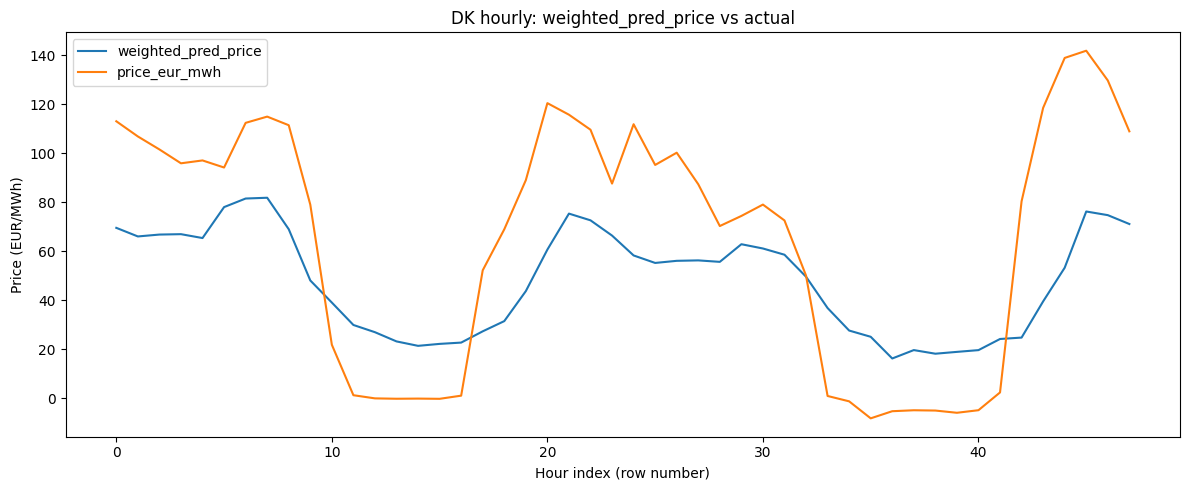

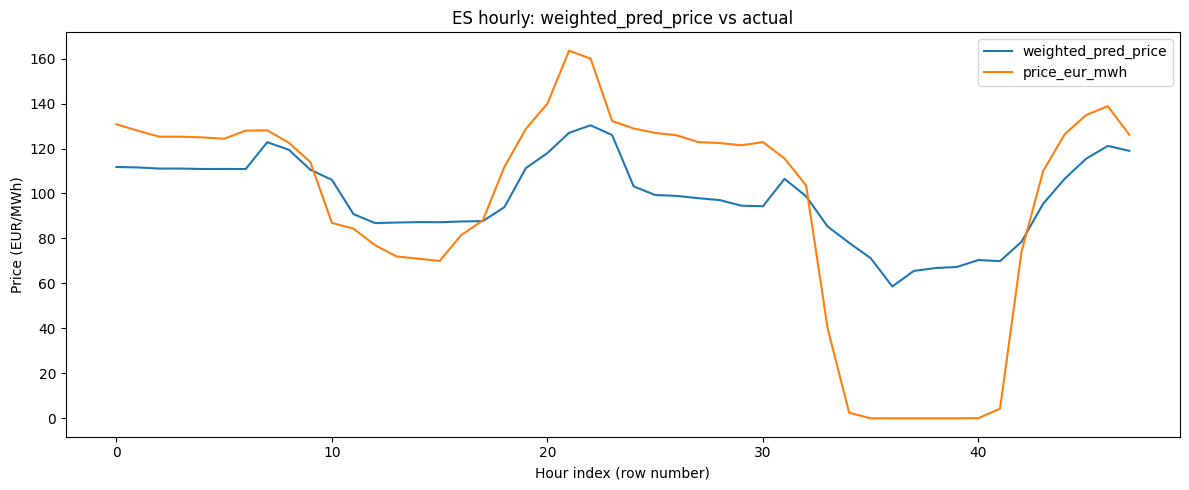

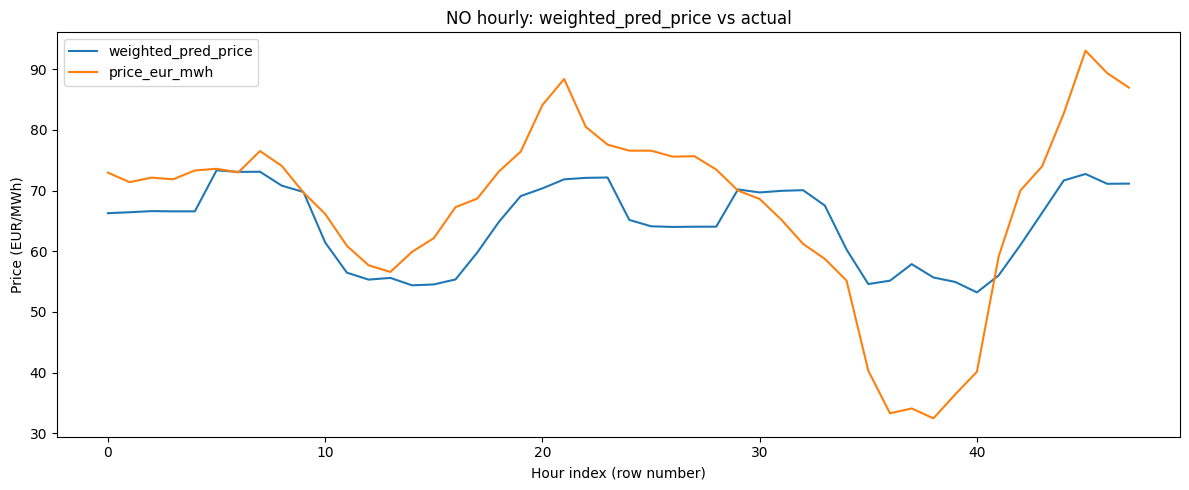

In [60]:
import matplotlib.pyplot as plt

def plot_hourly_series(df, title,
                       pred_col="weighted_pred_price",
                       actual_col="price_eur_mwh"):
    """
    Plot hourly values using the row index as x-axis (0..N-1).
    This guarantees every hourly row is shown, independent of the date axis.
    """
    d = df.reset_index(drop=True)  # make x-axis clean: 0..N-1

    plt.figure(figsize=(12, 5))
    plt.plot(d[pred_col].to_numpy(), label=pred_col)
    plt.plot(d[actual_col].to_numpy(), label=actual_col)
    plt.title(title)
    plt.xlabel("Hour index (row number)")
    plt.ylabel("Price (EUR/MWh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hourly_series(df_dk_plot, "DK hourly: weighted_pred_price vs actual")
plot_hourly_series(df_es_plot, "ES hourly: weighted_pred_price vs actual")
plot_hourly_series(df_no_plot, "NO hourly: weighted_pred_price vs actual")

### Evaluation
The next function calculates the MAE (mean absolute error), sMAPE (symmetric mean absolute percentage error) and the WAPE (weighted absolute percentage error) of the predictions over the course of the whole test data. The WAPE serves as deciding metric for the quality of the prediction models. The lower the WAPE, the better.

In [61]:
def avg_errors(df, pred_col="weighted_pred_price", actual_col="price_eur_mwh"):
    """
    Returns:
      - MAE: mean absolute error (same unit as price)
      - sMAPE: symmetric mean absolute percentage error (in %)
      - WAPE: weighted absolute percentage error (in %)
    """
    x = df[[actual_col, pred_col]].dropna()
    
    y_true = x[actual_col].to_numpy(dtype=float)
    y_pred = x[pred_col].to_numpy(dtype=float)

    # MAE
    abs_err = np.abs(y_pred - y_true)
    mae = abs_err.mean()

    # sMAPE
    denom = np.abs(y_true) + np.abs(y_pred)
    mask_smape = denom != 0
    smape = (2 * abs_err[mask_smape] / denom[mask_smape]).mean() * 100 if mask_smape.any() else np.nan

    # WAPE
    denom_wape = np.abs(y_true).sum()
    wape = (abs_err.sum() / denom_wape) * 100 if denom_wape != 0 else np.nan

    return mae, smape, wape

mae_dk, smape_dk, wape_dk = avg_errors(pred_dk)
mae_es, smape_es, wape_es = avg_errors(pred_es)
mae_no, smape_no, wape_no = avg_errors(pred_no)

print(f"DK -> MAE: {mae_dk:.2f} EUR/MWh | sMAPE: {smape_dk:.2f}% | WAPE: {wape_dk:.2f}%")
print(f"ES -> MAE: {mae_es:.2f} EUR/MWh | sMAPE: {smape_es:.2f}% | WAPE: {wape_es:.2f}%")
print(f"NO -> MAE: {mae_no:.2f} EUR/MWh | sMAPE: {smape_no:.2f}% | WAPE: {wape_no:.2f}%")

DK -> MAE: 24.33 EUR/MWh | sMAPE: 50.49% | WAPE: 31.45%
ES -> MAE: 23.00 EUR/MWh | sMAPE: 54.14% | WAPE: 33.84%
NO -> MAE: 15.62 EUR/MWh | sMAPE: 31.18% | WAPE: 23.28%


## Part 4: Naive approaches

To enable comparison for the models obtained in part 3, 2 naive approach prediction models are leveraged.

#### Naive approach 1
For naive approach 1, the real prices of the day before are assumed to be the true prices of the current day.

#### Naive approach 2
For naive approach 2, no clusters are predicted. Therefore, naive approach 2 does not follow a 3 step process (with step 1 being the prediction of the clusters,  step 2 the prediction of the prices within the clusters and step 3 the combination of step 1 and step 2 by weighing the single price predictions with cluster probabilities).
Instead, naive approach 2 directly leverages the weather variables as covariates for the hourly price.

#### Naive approach 1

For naive approach 1 the hourly data for the following time frames is needed, in order to compare the results to the above created prediction models.

- Denmark: 2025-06-18 to 2025-11-23
- Spain: 2025-06-20 to 2025-11-26
- Norway: 2025-06-20 to 2025-11-26

Therefore, the hourly data is loaded first.

In [62]:
df_dk_naive_one = df_dk_original.copy()
df_es_naive_one = df_es_original.copy()
df_no_naive_one = df_no_original.copy()
df_dk_naive_one

,Unnamed: 0,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,1.38,6.745026,2.652963,1.400332,0.00000
1,2023-01-01 02:00:00+01:00,0.09,6.788788,2.162854,1.195239,0.00000
2,2023-01-01 03:00:00+01:00,0.08,6.770447,2.242519,0.880637,0.00000
3,2023-01-01 04:00:00+01:00,0.05,6.767029,2.137281,0.679594,0.00000
4,2023-01-01 05:00:00+01:00,0.00,6.659546,2.341132,0.574855,0.00000
...,...,...,...,...,...,...
25395,2025-11-24 10:00:00+01:00,117.45,2.856812,6.390077,0.293989,27.68526
25396,2025-11-24 11:00:00+01:00,127.94,2.830780,6.255614,0.266801,54.39607
25397,2025-11-24 12:00:00+01:00,128.35,2.989014,5.956007,0.217965,79.10516
25398,2025-11-24 13:00:00+01:00,149.73,3.152435,5.755936,0.183517,84.64069


### Rename data_time column

### Rename date_time column
For more intuitive understanding the date_time column is renamed.

In [63]:
df_dk_naive_one = df_dk_naive_one.rename(columns={"Unnamed: 0": "date_time"})
df_es_naive_one = df_es_naive_one.rename(columns={"Unnamed: 0": "date_time"})
df_no_naive_one = df_no_naive_one.rename(columns={"Unnamed: 0": "date_time"})
df_dk_naive_one

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,1.38,6.745026,2.652963,1.400332,0.00000
1,2023-01-01 02:00:00+01:00,0.09,6.788788,2.162854,1.195239,0.00000
2,2023-01-01 03:00:00+01:00,0.08,6.770447,2.242519,0.880637,0.00000
3,2023-01-01 04:00:00+01:00,0.05,6.767029,2.137281,0.679594,0.00000
4,2023-01-01 05:00:00+01:00,0.00,6.659546,2.341132,0.574855,0.00000
...,...,...,...,...,...,...
25395,2025-11-24 10:00:00+01:00,117.45,2.856812,6.390077,0.293989,27.68526
25396,2025-11-24 11:00:00+01:00,127.94,2.830780,6.255614,0.266801,54.39607
25397,2025-11-24 12:00:00+01:00,128.35,2.989014,5.956007,0.217965,79.10516
25398,2025-11-24 13:00:00+01:00,149.73,3.152435,5.755936,0.183517,84.64069


### Select the right rows
Since not all rows of the original data are needed for testing, next only the needed rows are selected.

In [64]:
# Drop the last 15 rows of *df_dk_naive_one*, because they are out of time frame.
df_dk_naive_one = df_dk_naive_one[:-15]
df_dk_naive_one

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
0,2023-01-01 01:00:00+01:00,1.38,6.745026,2.652963,1.400332,0.0
1,2023-01-01 02:00:00+01:00,0.09,6.788788,2.162854,1.195239,0.0
2,2023-01-01 03:00:00+01:00,0.08,6.770447,2.242519,0.880637,0.0
3,2023-01-01 04:00:00+01:00,0.05,6.767029,2.137281,0.679594,0.0
4,2023-01-01 05:00:00+01:00,0.00,6.659546,2.341132,0.574855,0.0
...,...,...,...,...,...,...
25380,2025-11-23 19:00:00+01:00,83.80,3.034515,9.009330,0.052493,0.0
25381,2025-11-23 20:00:00+01:00,77.41,2.891785,8.958768,0.056595,0.0
25382,2025-11-23 21:00:00+01:00,74.16,2.675384,8.867300,0.075576,0.0
25383,2025-11-23 22:00:00+01:00,73.42,2.442291,8.639704,0.123786,0.0


In [65]:
# Only keep rows of the defined time frame + the day before, such that predictions can be made for the defined time frame.
df_dk_naive_one = df_dk_naive_one[-3839:]
df_es_naive_one = df_es_naive_one[-3863:]
df_no_naive_one = df_no_naive_one[-3863:]
df_dk_naive_one

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W
21546,2025-06-17 00:00:00+02:00,103.98,13.976501,6.748162,0.000000,0.0
21547,2025-06-17 01:00:00+02:00,91.84,13.873962,6.806303,0.000000,0.0
21548,2025-06-17 02:00:00+02:00,82.42,13.779755,6.567537,0.000000,0.0
21549,2025-06-17 03:00:00+02:00,78.39,13.738190,6.057462,0.000003,0.0
21550,2025-06-17 04:00:00+02:00,80.52,13.673950,5.686945,0.000000,0.0
...,...,...,...,...,...,...
25380,2025-11-23 19:00:00+01:00,83.80,3.034515,9.009330,0.052493,0.0
25381,2025-11-23 20:00:00+01:00,77.41,2.891785,8.958768,0.056595,0.0
25382,2025-11-23 21:00:00+01:00,74.16,2.675384,8.867300,0.075576,0.0
25383,2025-11-23 22:00:00+01:00,73.42,2.442291,8.639704,0.123786,0.0


### Get predictions
Now the predictions can be collected, by shifting the price by one day. By doing so, the first 24 rows of the column with the shifted entries are going to be NaN. These rows are therefore delted.

In [66]:
# Get predictions from the day before.
def naive_approach_one(df, dt_col="date_time", price_col="price_eur_mwh"):
    d = df.copy()

    # Ensure datetime type (keeps timezone)
    d[dt_col] = pd.to_datetime(d[dt_col], utc = True)

    # Build a lookup table: (date_time -> price)
    lookup = d[[dt_col, price_col]].rename(columns={price_col: "naive_one_pred_price"})
    lookup[dt_col] = lookup[dt_col] + pd.Timedelta(days=1)  # shift forward so we can merge

    # Merge: for each row at time t, get price from t-1day (now aligned via shift+merge)
    d = d.merge(lookup, on=dt_col, how="left")

    return d

df_dk_naive_one = naive_approach_one(df_dk_naive_one)
df_es_naive_one = naive_approach_one(df_es_naive_one)
df_no_naive_one = naive_approach_one(df_no_naive_one)

In [67]:
# Take a quick look.
df_no_naive_one[:26]

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,naive_one_pred_price
0,2025-06-18 22:00:00+00:00,74.50,11.015595,6.492290,0.059248,0.000000,NaN
1,2025-06-18 23:00:00+00:00,73.01,10.743225,6.495974,0.050256,0.000000,NaN
2,2025-06-19 00:00:00+00:00,70.81,10.600067,6.570500,0.034114,0.000000,NaN
3,2025-06-19 01:00:00+00:00,69.37,10.279968,6.730488,0.024806,0.000000,NaN
4,2025-06-19 02:00:00+00:00,67.33,10.191101,6.743518,0.021860,0.000000,NaN
5,2025-06-19 03:00:00+00:00,67.13,10.154694,6.572050,0.016838,4.789282,NaN
6,2025-06-19 04:00:00+00:00,66.20,10.428589,6.320789,0.020637,50.479640,NaN
7,2025-06-19 05:00:00+00:00,65.94,10.892029,6.244333,0.022849,139.418330,NaN
8,2025-06-19 06:00:00+00:00,59.99,11.565857,6.316226,0.020192,261.049960,NaN
9,2025-06-19 07:00:00+00:00,33.24,12.114716,6.208787,0.024093,381.665770,NaN


In [68]:
# Drop the first 24 columns in all dataframes again, because they do not have predictions.
df_dk_naive_one = df_dk_naive_one[24:]
df_es_naive_one = df_es_naive_one[24:]
df_no_naive_one = df_no_naive_one[24:]

In [69]:
df_no_naive_one

,date_time,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,naive_one_pred_price
24,2025-06-19 22:00:00+00:00,72.95,11.798401,4.950921,0.000035,0.0,74.50
25,2025-06-19 23:00:00+00:00,71.39,11.271179,4.586340,0.000130,0.0,73.01
26,2025-06-20 00:00:00+00:00,72.13,10.695679,4.130963,0.000081,0.0,70.81
27,2025-06-20 01:00:00+00:00,71.86,10.082916,3.862529,0.000000,0.0,69.37
28,2025-06-20 02:00:00+00:00,73.31,9.721008,3.785122,0.000008,0.0,67.33
...,...,...,...,...,...,...,...
3858,2025-11-26 18:00:00+00:00,158.23,2.369995,4.953863,0.043356,0.0,200.17
3859,2025-11-26 19:00:00+00:00,121.77,2.430481,5.726223,0.052232,0.0,139.29
3860,2025-11-26 20:00:00+00:00,99.64,2.612640,6.234687,0.056244,0.0,111.50
3861,2025-11-26 21:00:00+00:00,88.25,2.800568,6.834829,0.080703,0.0,98.55


### Visualization naive approach one
Below, the first 48 hours of the predicted prices (following naive approach one) and the true prices are plotted.

In [70]:
df_dk_naive_one_plot = df_dk_naive_one[:48]
df_es_naive_one_plot = df_es_naive_one[:48]
df_no_naive_one_plot = df_no_naive_one[:48]

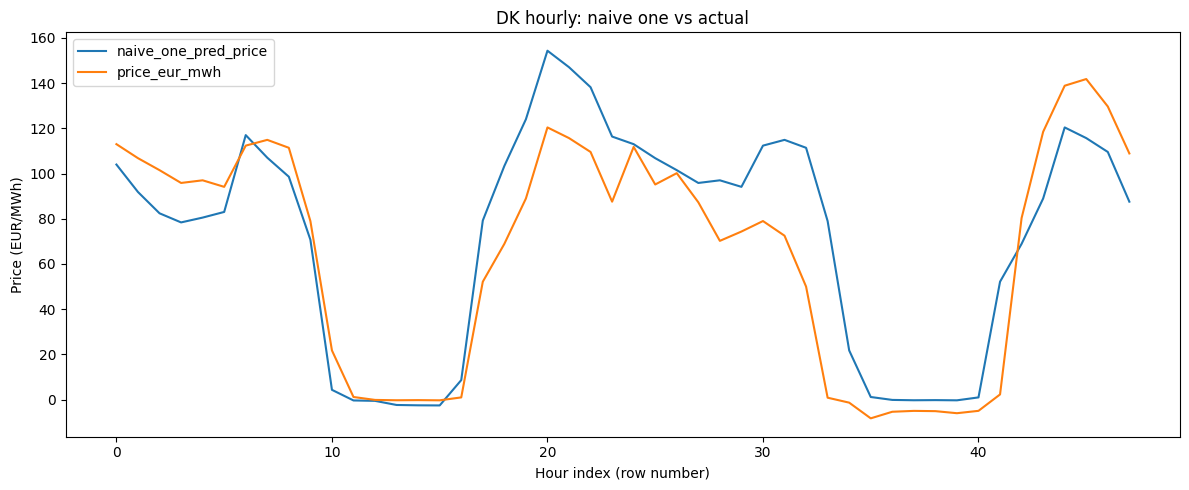

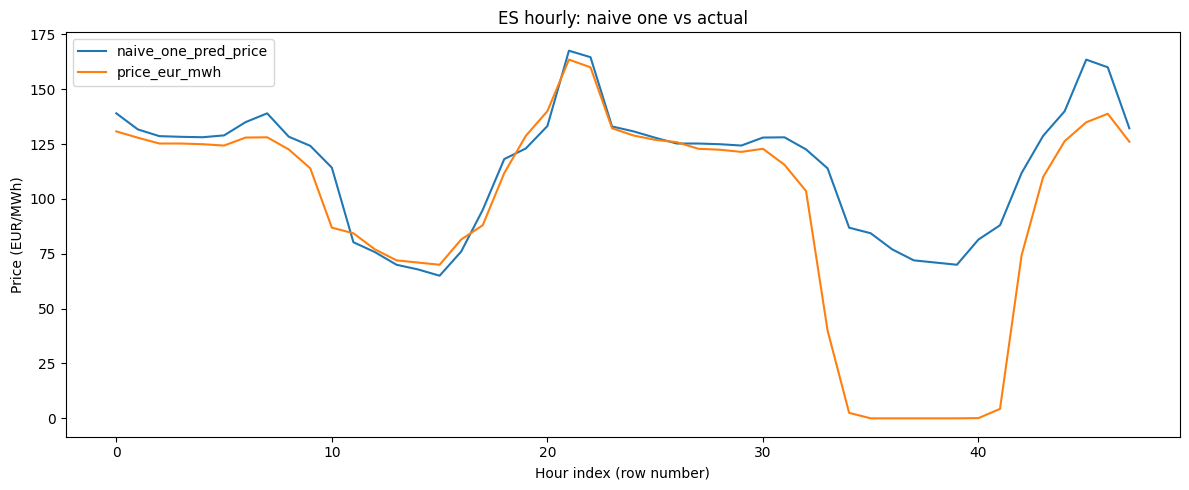

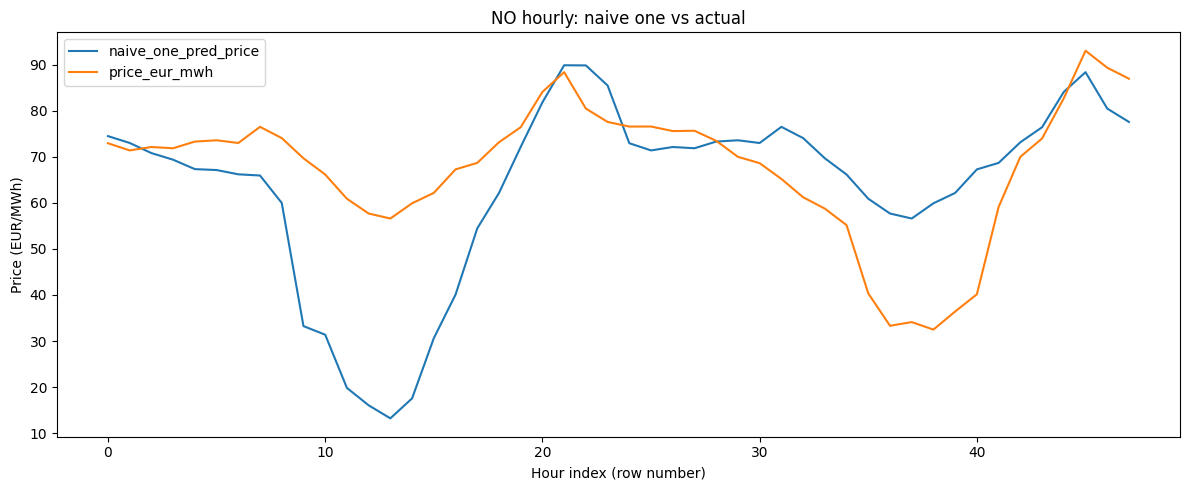

In [71]:
def plot_hourly_series_naive_one(df, title,
                       pred_col="naive_one_pred_price", actual_col="price_eur_mwh"):
    """
    Plot hourly values using the row index as x-axis (0..N-1).
    This guarantees every hourly row is shown, independent of the date axis.
    """
    d = df.reset_index(drop=True)  # make x-axis clean: 0..N-1

    plt.figure(figsize=(12, 5))
    plt.plot(d[pred_col].to_numpy(), label=pred_col)
    plt.plot(d[actual_col].to_numpy(), label=actual_col)
    plt.title(title)
    plt.xlabel("Hour index (row number)")
    plt.ylabel("Price (EUR/MWh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hourly_series_naive_one(df_dk_naive_one_plot, "DK hourly: naive one vs actual")
plot_hourly_series_naive_one(df_es_naive_one_plot, "ES hourly: naive one vs actual")
plot_hourly_series_naive_one(df_no_naive_one_plot, "NO hourly: naive one vs actual")

### Evaluation naive approach one

Due to the fact the clock was changed once during the period of the test data, the day shifting did not work for 2 entries, resulting in 2 NA values. Before the models can be evaluated by calculating the errors, these NAs must be deleted. After, The MAE, sMAPE and WAPE are calculated, just like for the cluster based models.

In [72]:
df_dk_naive_one = df_dk_naive_one.dropna(subset=["naive_one_pred_price"])
df_es_naive_one = df_es_naive_one.dropna(subset=["naive_one_pred_price"])
df_no_naive_one = df_no_naive_one.dropna(subset=["naive_one_pred_price"])

In [73]:
def avg_errors_naive_one(df, pred_col="naive_one_pred_price", actual_col="price_eur_mwh"):
    """
    Returns:
      - MAE: mean absolute error (same unit as price)
      - sMAPE: symmetric mean absolute percentage error (in %)
      - WAPE: weighted absolute percentage error (in %)
    """
    x = df[[actual_col, pred_col]].dropna()
    
    y_true = x[actual_col].to_numpy(dtype=float)
    y_pred = x[pred_col].to_numpy(dtype=float)

    # MAE
    abs_err = np.abs(y_pred - y_true)
    mae = abs_err.mean()

    # sMAPE
    denom = np.abs(y_true) + np.abs(y_pred)
    mask_smape = denom != 0
    smape = (2 * abs_err[mask_smape] / denom[mask_smape]).mean() * 100 if mask_smape.any() else np.nan

    # WAPE
    denom_wape = np.abs(y_true).sum()
    wape = (abs_err.sum() / denom_wape) * 100 if denom_wape != 0 else np.nan

    return mae, smape, wape

mae_dk_naive_one, smape_dk_naive_one, wape_dk_naive_one = avg_errors_naive_one(df_dk_naive_one)
mae_es_naive_one, smape_es_naive_one, wape_es_naive_one = avg_errors_naive_one(df_es_naive_one)
mae_no_naive_one, smape_no_naive_one, wape_no_naive_one = avg_errors_naive_one(df_no_naive_one)

print(f"DK -> MAE: {mae_dk_naive_one:.2f} EUR/MWh | sMAPE: {smape_dk_naive_one:.2f}% | WAPE: {wape_dk_naive_one:.2f}%")
print(f"ES -> MAE: {mae_es_naive_one:.2f} EUR/MWh | sMAPE: {smape_es_naive_one:.2f}% | WAPE: {wape_es_naive_one:.2f}%")
print(f"NO -> MAE: {mae_no_naive_one:.2f} EUR/MWh | sMAPE: {smape_no_naive_one:.2f}% | WAPE: {wape_no_naive_one:.2f}%")

DK -> MAE: 26.61 EUR/MWh | sMAPE: 57.99% | WAPE: 34.39%
ES -> MAE: 20.12 EUR/MWh | sMAPE: 58.83% | WAPE: 29.60%
NO -> MAE: 15.07 EUR/MWh | sMAPE: 34.03% | WAPE: 22.46%


### Export results
To visualize the prediction results on the external dahsboard, the prediction results are needed as csv files. These files are created and exported here.

In [130]:
# Prepare the dataframes with the predictions for exporting as csvs for the dahsboard.
df_dk_naive_one = df_dk_naive_one.drop(columns=["temperature_2m", "wind_speed_10m", "precipitation_mm", "solar_radiation_W"])
df_es_naive_one = df_es_naive_one.drop(columns=["temperature_2m", "wind_speed_10m", "precipitation_mm", "solar_radiation_W"])
df_no_naive_one = df_no_naive_one.drop(columns=["temperature_2m", "wind_speed_10m", "precipitation_mm", "solar_radiation_W"])

# Rename columns.
df_dk_naive_one = df_dk_naive_one.rename(columns={"price_eur_mwh" : "price_real", "naive_one_pred_price" : "price_predicted"})
df_es_naive_one = df_es_naive_one.rename(columns={"price_eur_mwh" : "price_real", "naive_one_pred_price" : "price_predicted"})
df_no_naive_one = df_no_naive_one.rename(columns={"price_eur_mwh" : "price_real", "naive_one_pred_price" : "price_predicted"})

# Change column order.
df_dk_naive_one = df_dk_naive_one[["price_real", "price_predicted", "date_time"]]
df_es_naive_one = df_es_naive_one[["price_real", "price_predicted", "date_time"]]
df_no_naive_one = df_no_naive_one[["price_real", "price_predicted", "date_time"]]

# Safe the predictions of the test data as csvs.
df_dk_naive_one.to_csv("DK_predictions_naive_one_approach.csv", index = False)
df_es_naive_one.to_csv("ES_predictions_naive_one_approach.csv", index = False)
df_no_naive_one.to_csv("NO_predictions_naive_one_approach.csv", index = False)

In [129]:
df_no_naive_one

,price_real,price_predicted,date_time
24,72.95,74.50,2025-06-19 22:00:00+00:00
25,71.39,73.01,2025-06-19 23:00:00+00:00
26,72.13,70.81,2025-06-20 00:00:00+00:00
27,71.86,69.37,2025-06-20 01:00:00+00:00
28,73.31,67.33,2025-06-20 02:00:00+00:00
...,...,...,...
3858,158.23,200.17,2025-11-26 18:00:00+00:00
3859,121.77,139.29,2025-11-26 19:00:00+00:00
3860,99.64,111.50,2025-11-26 20:00:00+00:00
3861,88.25,98.55,2025-11-26 21:00:00+00:00


### Naive Approach 2
For naive approach 2, the hourly weather variables for temperature, wind speed and irradiance as well as the aggregated precipitation (for the same number of days as for the cluster models above) are directly leveraged as covariates for the hourly energy price level. To start, the whole hourly data with the according number of days for precipitation aggregation is loaded.

In [74]:
df_dk_data_hourly_naive_two = dfs_agg_precipitation_part3["dk"][20]
df_es_data_hourly_naive_two = dfs_agg_precipitation_part3["es"][20]
df_no_data_hourly_naive_two = dfs_agg_precipitation_part3["no"][7]
df_dk_data_hourly_naive_two

,price_eur_mwh,temperature_2m,wind_speed_10m,precipitation_mm,solar_radiation_W,date,cluster,precipitation_last_20_days
0,1.38,6.745026,2.652963,1.400332,0.0,2023-01-01,5,NaN
1,0.09,6.788788,2.162854,1.195239,0.0,2023-01-01,5,NaN
2,0.08,6.770447,2.242519,0.880637,0.0,2023-01-01,5,NaN
3,0.05,6.767029,2.137281,0.679594,0.0,2023-01-01,5,NaN
4,0.00,6.659546,2.341132,0.574855,0.0,2023-01-01,5,NaN
...,...,...,...,...,...,...,...,...
25380,83.80,3.034515,9.009330,0.052493,0.0,2025-11-23,3,33.319312
25381,77.41,2.891785,8.958768,0.056595,0.0,2025-11-23,3,33.319312
25382,74.16,2.675384,8.867300,0.075576,0.0,2025-11-23,3,33.319312
25383,73.42,2.442291,8.639704,0.123786,0.0,2025-11-23,3,33.319312


### Drop NaNs and unnecessary columns
Rows with to little days before for the aggregation of precipitation to work (e.g. the first 7 days if precipitation is aggregated for the last 7 days) hold NaNs. These rows and the columns *precipitation_mm* as well as *date* and *cluster* are dropped, because they are not needed for predictions of naive approach 2.

In [75]:
# Drop the columns where no precipitation for the last x days could be calculated, because too little days lay behind.
df_dk_data_hourly_naive_two = df_dk_data_hourly_naive_two.dropna(subset=["precipitation_last_20_days"])
df_es_data_hourly_naive_two = df_es_data_hourly_naive_two.dropna(subset=["precipitation_last_20_days"])
df_no_data_hourly_naive_two = df_no_data_hourly_naive_two.dropna(subset=["precipitation_last_7_days"])

In [76]:
# Drop columns unnecessary for the predictions.
df_dk_data_hourly_naive_two = df_dk_data_hourly_naive_two.drop(columns=["precipitation_mm", "date", "cluster"])
df_es_data_hourly_naive_two = df_es_data_hourly_naive_two.drop(columns=["precipitation_mm", "date", "cluster"])
df_no_data_hourly_naive_two = df_no_data_hourly_naive_two.drop(columns=["precipitation_mm", "date", "cluster"])
df_dk_data_hourly_naive_two

,price_eur_mwh,temperature_2m,wind_speed_10m,solar_radiation_W,precipitation_last_20_days
479,144.13,1.547180,3.899708,0.0,114.269932
480,140.06,1.524506,3.941162,0.0,114.269932
481,140.19,1.441040,3.949498,0.0,114.269932
482,133.74,1.413391,3.985501,0.0,114.269932
483,131.24,1.306732,4.060265,0.0,114.269932
...,...,...,...,...,...
25380,83.80,3.034515,9.009330,0.0,33.319312
25381,77.41,2.891785,8.958768,0.0,33.319312
25382,74.16,2.675384,8.867300,0.0,33.319312
25383,73.42,2.442291,8.639704,0.0,33.319312


### Predict, evaluate, plot
In the next cell

- the above prepared data is used to train the XGBoost regression model for naive approach 2 (data split 70/15/15 as with the other models),
- the obtained model is evaluated with MAE, sMAPE and WAPE,
- the first 48 hours of the predictions are plotted vs. the real values.

DK -> MAE: 25.97 EUR/MWh | sMAPE: 50.77% | WAPE: 33.56%
DK -> train=17434, val=3735, test=3737


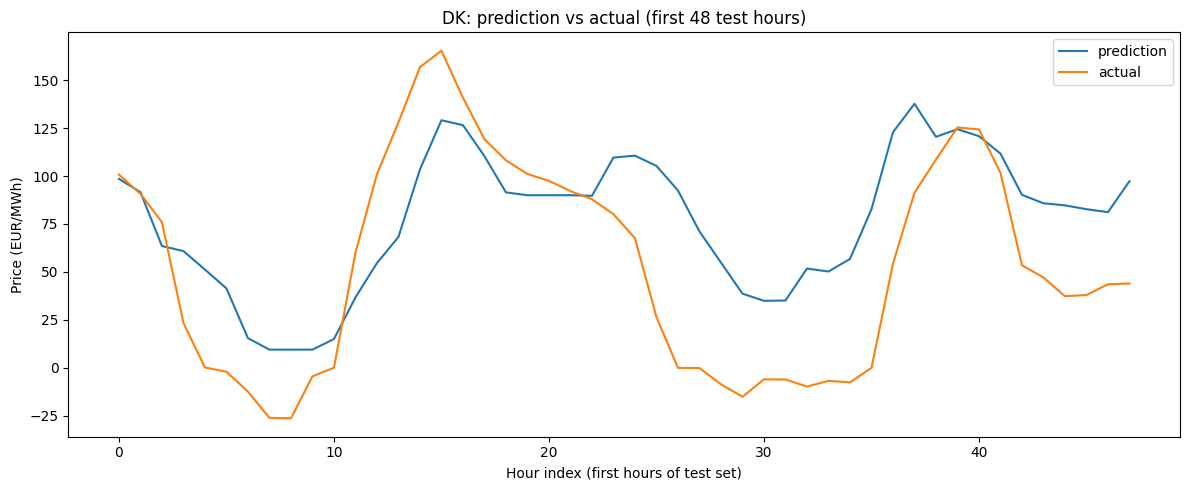

ES -> MAE: 27.47 EUR/MWh | sMAPE: 57.19% | WAPE: 40.70%
ES -> train=17484, val=3746, test=3748


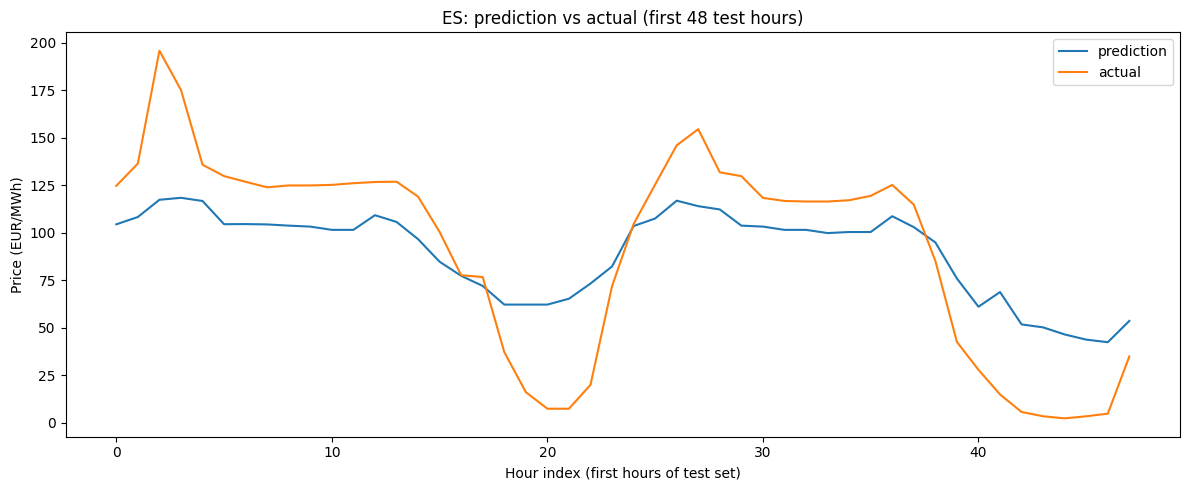

NO -> MAE: 20.46 EUR/MWh | sMAPE: 39.29% | WAPE: 30.49%
NO -> train=17703, val=3793, test=3794


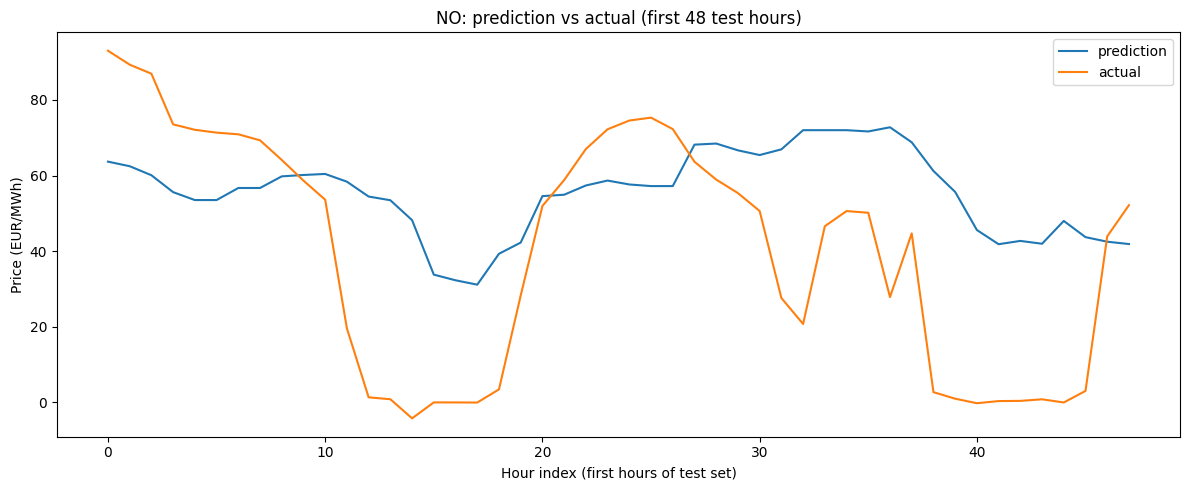

Saved models:
naive_approach_2/naive_two_dk.joblib
naive_approach_2/naive_two_es.joblib
naive_approach_2/naive_two_no.joblib


In [134]:
# Safe the models here.
MODEL_DIR = Path("naive_approach_2")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# This function helps to calculate MAE, sMAPE and WAPE.
def mae_smape_wape(y_true, y_pred):
    # Convert to numpy arrays (float) to avoid dtype issues
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    abs_err = np.abs(y_pred - y_true)
    # MAE
    mae = abs_err.mean()

    # sMAPE
    denom_smape = np.abs(y_true) + np.abs(y_pred)
    mask_smape = denom_smape != 0
    smape = (2 * abs_err[mask_smape] / denom_smape[mask_smape]).mean() * 100 if mask_smape.any() else np.nan

    # WAPE
    denom_wape = np.abs(y_true).sum()
    wape = (abs_err.sum() / denom_wape) * 100 if denom_wape != 0 else np.nan

    return mae, smape, wape


# This function trains, evaluates, saves and plots the results of naive approach 2.
def train_eval_save_xgb(df: pd.DataFrame, model_name: str, label: str,
                        target_col: str = "price_eur_mwh",
                        train_frac: float = 0.70, val_frac: float = 0.15,
                        random_state: int = 42,
                        plot_n: int = 48):

    d = df.reset_index(drop=True).copy()

    # Split into target and features
    y = d[target_col]
    X = d.drop(columns=[target_col], errors="ignore")

    # Store feature column order for consistent inference later
    feature_cols = X.columns.tolist()

    # Chronological split by row order: 70/15/15
    n = len(d)
    n_train = int(np.floor(n * train_frac))
    n_val = int(np.floor(n * val_frac))

    X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
    X_val,   y_val   = X.iloc[n_train:n_train+n_val], y.iloc[n_train:n_train+n_val]
    X_test,  y_test  = X.iloc[n_train+n_val:], y.iloc[n_train+n_val:]

    model = XGBRegressor(
        n_estimators=2000,          # large; early stopping will probably stop earlier
        learning_rate=0.05,         # learning rate; indicating allowed improvement per new tree
        max_depth=6,                # maximum depth of each tree
        subsample=0.9,              # bagging; only use random 90% subsample of rows per tree
        colsample_bytree=0.9,       # random sub space; only use random 90% of features per tree
        reg_lambda=1.0,             # regularization strength on leaf weights (helps reduce overfitting)
        objective="reg:squarederror",# telling the model to do regression and minimize the squared error
        random_state=random_state,  # reproducibility (controls randomness in subsampling/column sampling)
        n_jobs=-1,                  # use all available CPU cores for faster training
        eval_metric="rmse",         # tell the model to use RMSE as evaluation metric to decide when to stop training
        early_stopping_rounds=50    # stop training if the validation metric doesn't improve for 50 rounds
    )

    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Test the model
    y_pred = model.predict(X_test).astype(float)
    y_true = y_test.to_numpy(dtype=float)

    pred_df_test = pd.DataFrame(
        {"price_real": y_true, "price_predicted": y_pred},
        index=y_test.index
    )

    # Call the helper function above to obtain MAE, sMAPE and WAPE
    mae, smape, wape = mae_smape_wape(y_true, y_pred)

    print(f"{label} -> MAE: {mae:.2f} EUR/MWh | sMAPE: {smape:.2f}% | WAPE: {wape:.2f}%")
    print(f"{label} -> train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

    # Plot only the first plot_n test hours
    n_plot = min(plot_n, len(y_true))           # don't exceed available length
    hour_idx = np.arange(n_plot)

    plt.figure(figsize=(12, 5))
    plt.plot(hour_idx, y_pred[:n_plot], label="prediction")
    plt.plot(hour_idx, y_true[:n_plot], label="actual")
    plt.title(f"{label}: prediction vs actual (first {n_plot} test hours)")
    plt.xlabel("Hour index (first hours of test set)")
    plt.ylabel("Price (EUR/MWh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save the model bundle.
    bundle = {
        "model": model,
        "feature_cols": feature_cols,
        "metrics": {
            "mae": float(mae),
            "smape_pct": float(smape) if not np.isnan(smape) else np.nan,
            "wape_pct": float(wape) if not np.isnan(wape) else np.nan
        },
        "splits": {
            "n_rows": int(n),
            "train_end": int(n_train),
            "val_end": int(n_train+n_val),
            "train_frac": float(train_frac),
            "val_frac": float(val_frac)
        }
    }

    save_path = MODEL_DIR / f"{model_name}.joblib"
    joblib.dump(bundle, save_path)

    return model, save_path, pred_df_test


# Call the function above to train the models.
model_dk_naive_two, path_dk_naive_two, df_dk_naive_two_output = train_eval_save_xgb(df_dk_data_hourly_naive_two, "naive_two_dk", "DK")
model_es_naive_two, path_es_naive_two, df_es_naive_two_output = train_eval_save_xgb(df_es_data_hourly_naive_two, "naive_two_es", "ES")
model_no_naive_two, path_no_naive_two, df_no_naive_two_output = train_eval_save_xgb(df_no_data_hourly_naive_two, "naive_two_no", "NO")

print("Saved models:")
print(path_dk_naive_two)
print(path_es_naive_two)
print(path_no_naive_two)

### Export results naive approach two
Lastly, the predictions results of naive approach two are exported as csv files, such that they can be visualized on the external dashboard.

In [176]:
# Prepare the dataframes for output as csv.
df_dk_naive_two_helper = df_dk_original[21648:25385]
df_es_naive_two_helper = df_es_original[21709:]
df_no_naive_two_helper = df_no_original[21663:]

# Add date_time.
df_dk_naive_two_output["date_time"] = df_dk_naive_two_helper["Unnamed: 0"].to_numpy()
df_es_naive_two_output["date_time"] = df_es_naive_two_helper["Unnamed: 0"].to_numpy()
df_no_naive_two_output["date_time"] = df_no_naive_two_helper["Unnamed: 0"].to_numpy()

# Export as csv.
df_dk_naive_two_output.to_csv("DK_predictions_naive_two_approach.csv", index = False)
df_es_naive_two_output.to_csv("ES_predictions_naive_two_approach.csv", index = False)
df_no_naive_two_output.to_csv("NO_predictions_naive_two_approach.csv", index = False)

In [175]:
df_dk_naive_two_output

,price_real,price_predicted,date_time
21230,124.72,104.471138,2025-06-23 19:00:00+02:00
21231,136.43,108.317429,2025-06-23 20:00:00+02:00
21232,195.77,117.369019,2025-06-23 21:00:00+02:00
21233,175.14,118.420433,2025-06-23 22:00:00+02:00
21234,135.82,116.742935,2025-06-23 23:00:00+02:00
...,...,...,...
24973,142.01,67.142143,2025-11-26 19:00:00+01:00
24974,124.83,55.359131,2025-11-26 20:00:00+01:00
24975,100.21,55.551014,2025-11-26 21:00:00+01:00
24976,91.89,62.298794,2025-11-26 22:00:00+01:00
